In [1]:
import numpy as np
import numpy_financial as npf
import pandas as pd
from pandas_datareader.data import DataReader as dr
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter
from matplotlib import gridspec
import mplfinance as mpf
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.stats import norm
import os
import datetime
import statsmodels.api as sm
import base64
from io import StringIO, BytesIO
import matplotlib.dates as mdates

# this module is utilized to prevent the annotations in the plot from overlapping
from adjustText import adjust_text

# Get Yahoo Finance Data
import yfinance as yf

# Library for Website creation
import streamlit as st
st.set_option('deprecation.showPyplotGlobalUse', False)

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:

def convert_date_index(df):
    # Convert the index to datetime
    df.index = pd.to_datetime(df.index)
    # Extract the month and year from the datetime
    df.index = df.index.strftime("%b %Y")
    return df

def create_performance_index(price_df):
    returns = price_df.pct_change()
    growth = returns+1
    growth = growth.fillna(1) # set starting value for index
    index = growth.cumprod()
    index = index - 1 # deduct starting value to get the percentage change
    return index

def visualize_performance(prices, list_of_names):
    benchmarking_data = create_performance_index(prices)
   
    color_list = ['deepskyblue', 'steelblue', 'mediumslateblue', 'cornflowerblue', 'lightsteelblue', 
                    'mediumslateblue', 'lightblue']

    benchmarking_data_filtered = benchmarking_data.filter(list_of_names)
    if len(list_of_names) > 0:
        benchmarking_data_filtered.plot(figsize=(15, 10), color=color_list)
    else:
        plt.figure(figsize=(15, 10))

    
    plt.fill_between(benchmarking_data.index, benchmarking_data.max(axis=1), benchmarking_data.min(axis=1),
                        color='grey', alpha=0.17, label="Range of all assets")

    # Calculate the number of days to add
    num_days = (benchmarking_data_filtered.index.max() - benchmarking_data_filtered.index.min()).days
    days_to_add1 = num_days / 100
    days_to_add2 = num_days / 13

    # Plot scatter points at the end of each line
    for col in benchmarking_data_filtered.columns:
        plt.scatter(benchmarking_data_filtered.index[-1], benchmarking_data_filtered[col].iloc[-1], color=color_list[list_of_names.index(col)], zorder=5)
        #text lablel is offset by a number of days to the right
        plt.text(benchmarking_data_filtered.index[-1] + pd.Timedelta(days=days_to_add1), benchmarking_data_filtered[col].iloc[-1], str(round(benchmarking_data_filtered[col].iloc[-1]*100, 2))+"%",color=color_list[list_of_names.index(col)], size=12, verticalalignment='bottom')

    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:,.0%}'.format))
    plt.gca().xaxis.set_major_locator(MaxNLocator())
    plt.gca().set_xlim(left=benchmarking_data.head(1).index.max())

    plt.xlim(right=benchmarking_data.index.max() + pd.Timedelta(days=days_to_add2))  # Extend x-axis limit by number of days
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format dates to show month and year
    plt.grid('on', ls="--")
    plt.ylabel(f"Performance (indexed: {benchmarking_data.head(1).index.max().strftime('%d.%m.%Y')} = 0%)", fontsize=12)
    plt.legend(fontsize=12)

    # Rotate x-axis labels to be horizontal
    plt.xticks(rotation=0, ha='center')

    # Remove x-axis label
    plt.gca().set_xlabel('')

    plt.show()

def visualize_summary(summary):
    fontsize=8
    plt.rc('font', size=fontsize)    
    fig, (ax1, ax2) = plt.subplots(1, 2, clip_on=False)
    ax1.grid('on', ls="--")
    ax1.set_axisbelow(True)
    ax1.yaxis.grid(False)
    ax2.grid('on', ls="--")
    ax2.set_axisbelow(True)
    ax2.yaxis.grid(False)
    ax3 =  ax2.twiny()
    ax4 = ax1.twiny()
    ax1.xaxis.set_major_locator(MaxNLocator(nbins="auto"))
    ax2.xaxis.set_major_locator(MaxNLocator(nbins="auto"))
    ax3.xaxis.set_major_locator(MaxNLocator(nbins="auto"))
    ax4.xaxis.set_major_locator(MaxNLocator(prune='upper', nbins="auto"))
    x_dim = max(max(summary["mean return"]), max(summary['standard deviation'])) * 1.1
    height_of_fig = len(summary)*0.1
    ax1.set_position([0, 0, 0.35, height_of_fig])
    ax2.set_position([0.35, 0, 0.35, height_of_fig])
    ax1.set_xlim(left=0, right=x_dim)
    ax2.set_xlim(left=0, right=x_dim)
    ax3.set_xlim(left=0, right=x_dim)
    ax4.set_xlim(left=-x_dim, right=0)
    ax1.xaxis.set_major_formatter(plt.FuncFormatter('{:,.0%}'.format))
    ax2.xaxis.set_major_formatter(plt.FuncFormatter('{:,.0%}'.format))
    ax3.xaxis.set_major_formatter(plt.FuncFormatter('{:,.0%}'.format))
    ax4.xaxis.set_major_formatter(plt.FuncFormatter('{:,.0%}'.format))
    ax1.invert_xaxis()
    ax2.tick_params(left = False, bottom=False)
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    summary_sorted = summary.copy()
    summary_sorted["r/std"] = summary["mean return"] / summary['standard deviation']
    summary_sorted.sort_values("r/std", inplace=True)
    bar_width = 0.6  # Set a fixed width for the horizontal bars
    for index, row in summary_sorted.iterrows():
        ax1.barh(index, row['standard deviation'], height=bar_width, color="steelblue")
        ax2.barh(index,  row['mean return'], height=bar_width, color="deepskyblue")
        if row['mean return'] < 0:
            if abs(row['mean return']) > abs(row['standard deviation']):
                ax1.barh(index, abs(row['mean return']), height=bar_width, color="deepskyblue")
                ax1.barh(index, row['standard deviation'], height=bar_width, color="steelblue")
            if abs(row['mean return']) <= abs(row['standard deviation']):
                ax1.barh(index, row['standard deviation'], height=bar_width, color="steelblue")
                ax1.barh(index, abs(row['mean return']), height=bar_width, color="deepskyblue")
    ax1_patch = mpatches.Patch(color='deepskyblue', label='Mean return')
    ax1.legend(handles=[ax1_patch], fontsize=fontsize, frameon=False, loc='center', ncol=2, bbox_to_anchor=(1, 1+0.8/len(summary)))
    ax2_patch = mpatches.Patch(color='steelblue', label='Volatility')
    ax2.legend(handles=[ax2_patch], fontsize=fontsize, frameon=False, loc='center', ncol=2, bbox_to_anchor=(0, -0.8/len(summary)))
    plt.show()


def visualize_correlation(corr):
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["deepskyblue", "mediumslateblue", "slategrey"])
    mask = np.triu(corr, k=1)
    plt.figure(figsize=(12, 7))
    sns.heatmap(corr, annot=True, cmap=cmap, mask=mask, linewidths=5,
                annot_kws={'color':'white'})
    plt.show()

def portfolio_std(weights):
    portfolio_std = np.sum(weights * np.sum(weights * annualized_cov_returns, axis=1)) ** 0.5
    return portfolio_std

def portfolio_return(weights, returns):
    portfolio_return = np.sum(weights * returns)
    return portfolio_return

def negative_portfolio_SR(weights, rf, returns):
    return_p = portfolio_return(weights, returns)
    std_p = portfolio_std(weights)
    negative_sharpe_ratio = -1*(return_p - rf) / std_p
    return negative_sharpe_ratio

def negative_portfolio_utility(weights, returns):
    return_p = portfolio_return(weights, returns)
    std_p = portfolio_std(weights)
    negative_portfolio_utility = -1*(return_p - 0.5*A*std_p**2)
    return negative_portfolio_utility

def create_KPI_report(name, weights, rf, returns):
    KPIs = pd.DataFrame(index=[name])
    KPIs["portfolio return"] = portfolio_return(weights, returns)
    KPIs["protfolio std"] = portfolio_std(weights)
    KPIs["sharpe ratio"] = (KPIs["portfolio return"]- rf) / KPIs["protfolio std"]
    KPIs["utility"] = KPIs["portfolio return"] - 0.5*A*KPIs["protfolio std"]**2
    return KPIs

def create_portfolio_visual(name, summary, KPIs):
    plt.figure(figsize=(8, 8))   
    plt.pie(summary["weight"], wedgeprops=dict(width=0.45), 
            colors=['deepskyblue', 'steelblue', 'lightblue', 'lightsteelblue', 'cornflowerblue',
                    'mediumslateblue','thistle', 'dodgerblue', 'slategrey'],
            autopct='%.2f%%',pctdistance=0.8, startangle=90,labels=summary.index)
    plt.annotate(name, xy=(0,0), fontsize=30, va="center", ha="center")
    plt.annotate("E(r): {}%".format(float((KPIs["portfolio return"]*100).round(decimals=2))), 
                 xy=(-0.07,-0.18), fontsize=10, va="center", ha="right")
    plt.annotate("Vola: {}%".format(float((KPIs["protfolio std"]*100).round(decimals=2))), 
                 xy=(+0.07,-0.18), fontsize=10, va="center", ha="left")
    plt.show()

def create_mvf_cal_visual():
    #plot minimum varriance frontier and CAL
    color1 = 'cornflowerblue'
    color2 = 'darkmagenta'

    plt.figure(figsize=(15, 10))

    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:,.2%}'.format))
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:,.2%}'.format))
    plt.gca().set_xlim(left=0)
    plt.gca().set_xlim(right=max(max(summary["standard deviation"]),float(KPIs_ocp["protfolio std"]))*1.05)

    plt.scatter(summary["standard deviation"], summary["mean return"], color=color1)

    # capital allocation line

    # between std = 0 and std = std_orp_l
    std_cal_1 = np.arange(0, float(KPIs_orp_l["protfolio std"]), step)
    return_cal_1 = rf_l + float(KPIs_orp_l["sharpe ratio"])*std_cal_1
    plt.plot(std_cal_1 ,return_cal_1, color=color1, label='Capital allocation line')

    # between std_orp_l and std_orp_b -> follows minimum varriance frontier
    mvf_plot_slice = mvf_plot_data[(mvf_plot_data["return"] >= float(KPIs_orp_l["portfolio return"])) & 
                               (mvf_plot_data["return"] <= float(KPIs_orp_b["portfolio return"]))]
    std_cal_2 = mvf_plot_slice["std"]
    return_cal_2 = mvf_plot_slice["return"]
    plt.plot(std_cal_2,return_cal_2,color=color1)

    # after std_orp_b
    endpoint_cal = plt.gca().get_xlim()[1] 
    std_cal_3 = np.arange(float(KPIs_orp_b["protfolio std"]), endpoint_cal, step)
    return_cal_3 = rf_b + float(KPIs_orp_b["sharpe ratio"])*std_cal_3
    plt.plot(std_cal_3 ,return_cal_3, color=color1)

    # minimum varriance frontier
    plt.plot(mvf_plot_data["std"], mvf_plot_data["return"], color=color1, linestyle='--',
         label='Minimum varriance frontier')

    plt.scatter(KPIs_mvp["protfolio std"], KPIs_mvp["portfolio return"], color=color2)
    plt.scatter(KPIs_orp["protfolio std"], KPIs_orp["portfolio return"], color=color2)
    plt.scatter(KPIs_ocp["protfolio std"], KPIs_ocp["portfolio return"], color=color2)

    plt.legend(fontsize=12)
    plt.xlabel("Volatility", fontsize=12)
    plt.ylabel("Mean return", fontsize=12)
    plt.grid('on', ls="--")

    # labeling
    x_offset = plt.gca().get_xlim()[1]*0.01
    for i in summary_p.index:
        plt.annotate(i,(summary_p["protfolio std"][i], summary_p["portfolio return"][i]),
                 (summary_p["protfolio std"][i]-x_offset, summary_p["portfolio return"][i]), 
                 color=color2, fontsize=12, ha='right')   

    labels = []
    for i in summary.index:
        labels.append(plt.text(summary["standard deviation"][i], summary["mean return"][i], i, size=8))
    adjust_text(labels) 
    
    plt.show()

def currency_formatter_alt_EUR_decimal_seperator(x, currency="EUR"):
         if currency == 'EUR':
            return f'{currency} {x:,.2f}'.replace(",", "X").replace(".", ",").replace("X", ".")
         elif currency == 'USD':
            return f'{currency} {x:,.2f}'
         
def currency_formatter(x, currency="EUR"):
    return f'{currency} {x:,.2f}'

def currency_formatter_signs(x, currency="EUR"):
         if currency == 'EUR':
            return f'€ {x:,.2f}'
         elif currency == 'USD':
            return f'$ {x:,.2f}'

def visualize_simulaiton(sim_avg, deposits, currency='EUR'):
    """
    Plots the average simulated performance over time.
    
    Parameters:
    sim_avg (DataFrame): A DataFrame containing the average simulated performance.
    currency (str): The currency in which to display the performance data.
    
    Returns:
    None
    """
    def currency_formatter(x, pos):
         if currency == 'EUR':
            return f'€ {x:,.2f}'
         elif currency == 'USD':
            return f'$ {x:,.2f}'
    
    plt.figure(figsize=(15, 5))
    
    # Set the y-axis formatter
    plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))
    
    # Set the tick locations and labels
    plt.xticks(sim_avg.index)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0f}'.format))
    
    # Plot the bars
    if sim_avg.iloc[-1] > deposits[-1]:
        plt.bar(sim_avg.index, sim_avg, color='deepskyblue', label="Capital", align='center')
        plt.bar(sim_avg.index, deposits, color='steelblue', label="Money invested", align='center')
    if sim_avg.iloc[-1] < deposits[-1]:
        plt.bar(sim_avg.index, deposits, color='steelblue', label="Money invested", align='center')
        plt.bar(sim_avg.index, sim_avg, color='deepskyblue', label="Capital", align='center')

    # Set the x-axis limits based on the minimum and maximum values in the index
    plt.gca().set_xlim(left=sim_avg.index.min()-0.8)
    plt.gca().set_xlim(right=sim_avg.index.max()+0.8)
    
    # Rotate xticks if needed
    if len(sim_avg.index) > 22:
        plt.xticks(rotation=45)
    if len(sim_avg.index) > 60:
        plt.xticks(rotation=90)
    if len(sim_avg.index) > 75:
        plt.gca().tick_params(axis='x', labelsize=8)
        
    plt.gca().set_axisbelow(True)
    plt.grid('on', ls="--")
    plt.gca().xaxis.grid(False)
    plt.legend(fontsize=12)
    
    plt.show()

def generate_excel_download_link(df):
    towrite = BytesIO()
    df.to_excel(towrite, index=False, header=True)
    towrite.seek(0)
    b64 = base64.b64encode(towrite.read()).decode()
    href = f'<a href="data:application/vnd.openxmlformats-officedocument.spreadsheetml.sheet;base64,{b64}" download="template.xlsx">Excel template'
    return st.markdown(href, unsafe_allow_html=True)

def maximum_drawdowns(price_df):
    """
    Calculate the maximum drawdowns of a dataframe of asset prices.

    Parameters:
    price_df (pd.DataFrame): A pandas DataFrame containing asset prices.
    (date index must be sorted ascending)

    Returns:
    pd.Series: Series of asset names and corresponding maximum drawdowns.
    """
    price_df_sorted = price_df.sort_index(ascending=True)
    max_price_df = price_df_sorted.rolling(window=len(price_df_sorted),min_periods=1).max()
    dd_price_df = price_df_sorted / max_price_df -1
    max_dd_series = dd_price_df.min()

    return max_dd_series

def get_monthly_closing_prices(price_df_daily): 
    price_df_monthly = price_df_daily.loc[price_df_daily.groupby(price_df_daily.index.to_period('M')).apply(lambda x: x.index.max())]
    return price_df_monthly


In [3]:

option = st.sidebar.selectbox("What do you want to see?", ("Past performance", "Custom portfolio","Return correlation", "MVP, ORP and OCP", "Minimum varriance frontier and Capital allocation line", "CAPM", "Savings plan simulation", "Data"))

st.header("Portfolio Analysis")

#tickers = ["EMXC.DE", "XDWD.DE", "XSX6.DE", "EWG2.SG", "DTLE.L", "AAPL"]
tickers = ["AAPL", "MSFT", "^GSPC", "GOLD.SG"]
input_tickers = True


input_tickers = st.text_input("Enter the [Yahoo Finace](https://finance.yahoo.com) tickers of the assets you are interested in (seperated by comma). Make sure to select at least two.")
# [link](https://share.streamlit.io/mesmith027/streamlit_webapps/main/MC_pi/streamlit_app.py)
if input_tickers:
    tickers  = input_tickers.split(",")
    tickers = [x.strip() for x in tickers]

# generate dataframe for Excel template
template_df = pd.DataFrame(columns=["Yahoo finance ticker",	"Asset class", "Number of shares", "TER"], index=None)


custom_p = st.file_uploader("You can also upload a custom portfolio by filling out and uploading the Excel template below.", type="xlsx")
generate_excel_download_link(template_df)

if custom_p:
    custom_p_df = pd.read_excel(custom_p)
    tickers_template = list(custom_p_df["Yahoo finance ticker"])
    tickers += tickers_template

price_df = yf.download(tickers, period='max')["Adj Close"]
price_df = price_df.dropna()

eurusd = yf.download(["EURUSD=X","EUR=X"], period='max')["Adj Close"]
    

currency = "USD"

rf_l = 0

rf_b = 0

A = 10




2024-03-04 20:09:02.959 
  command:

    streamlit run c:\Users\Abler-Kratkey\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  2 of 2 completed


In [4]:

# Currency conversion and long name dictionary creation
curr_conv_tabl = pd.DataFrame(index=price_df.index, columns=price_df.columns)
curr_conv_tabl.fillna(1, inplace=True)

long_name_dict = {}
for col in curr_conv_tabl.columns:
    try:
        long_name_dict[col] = yf.Ticker(col).info["longName"]
        curr = yf.Ticker(col).info["currency"]
        if curr != currency:
            if currency == "EUR":
                    curr_conv_tabl[col] = curr_conv_tabl[col] * eurusd["EUR=X"]
            elif currency == "USD":
                    curr_conv_tabl[col] = curr_conv_tabl[col] * eurusd["EURUSD=X"] 
    except:
        pass
    
#Paste down last avalible EUR/USD rate (Dec 2003) for datapoints before that date
col_names = list(curr_conv_tabl.columns)
last_exch_rates = curr_conv_tabl.dropna().iloc[0,:].tolist()
last_exch_rate_dict = dict(zip(col_names, last_exch_rates))
curr_conv_tabl.fillna(last_exch_rate_dict, inplace=True)

price_df = price_df * curr_conv_tabl
    
daily_adjusted_closing_prices = price_df

#Calculate YTD returns
now = price_df.index[-1]
end_prev_y = price_df.index[price_df.index.year<now.year][-1]
ytd_returns = price_df.loc[now] / price_df.loc[end_prev_y] - 1

start_date = daily_adjusted_closing_prices.index.min().date()
end_date = daily_adjusted_closing_prices.index.max().date()
    
date_range = st.slider("Define the timeframe to be considered for the analysis.", value=[start_date, end_date], min_value=start_date, max_value=end_date, format ='DD.MM.YYYY')
start_date_from_index = daily_adjusted_closing_prices.index[(daily_adjusted_closing_prices.index.day==date_range[0].day) & (daily_adjusted_closing_prices.index.month==date_range[0].month) & (daily_adjusted_closing_prices.index.year==date_range[0].year)].min().date()
end_date_from_index = daily_adjusted_closing_prices.index[(daily_adjusted_closing_prices.index.day==date_range[1].day) & (daily_adjusted_closing_prices.index.month==date_range[1].month) & (daily_adjusted_closing_prices.index.year==date_range[1].year)].max().date()
daily_adjusted_closing_prices = daily_adjusted_closing_prices.loc[start_date_from_index:end_date_from_index]

montly_adjusted_closing_prices = get_monthly_closing_prices(price_df_daily=daily_adjusted_closing_prices)

    # calculate maximum drawdown
max_dds = maximum_drawdowns(price_df=daily_adjusted_closing_prices)
montly_adjusted_closing_prices

,AAPL,GOLD.SG,MSFT,^GSPC
Date,,,,
2012-09-28,20.2568,44.2900,24.0808,1440.6700
2012-10-31,18.0772,42.7100,23.0936,1412.1600
2012-11-30,17.8535,42.3300,21.7170,1416.1801
2012-12-28,15.5446,40.4000,21.6599,1402.4301
2013-01-31,13.8944,39.3300,22.3942,1498.1100
...,...,...,...,...
2023-11-30,189.7079,60.0300,378.2106,4567.7998
2023-12-29,192.2846,60.0000,375.3459,4769.8301
2024-01-31,184.1650,60.4000,396.8461,4845.6499


In [5]:
#montly_adjusted_closing_prices = convert_date_index(montly_adjusted_closing_prices)
monthly_log_returns = np.log(montly_adjusted_closing_prices / montly_adjusted_closing_prices.shift(1))

annualized_mean_returns = monthly_log_returns.mean() * 12
annualized_std_returns = monthly_log_returns.std() * 12**0.5
annualized_cov_returns = monthly_log_returns.cov() * 12
corr_returns = monthly_log_returns.corr()

summary = pd.DataFrame()

summary["mean return"] = annualized_mean_returns
summary["standard deviation"] = annualized_std_returns
summary["weight"] = 1/len(summary)

mvp_summary = summary.copy()
mvp = minimize(portfolio_std, x0=mvp_summary["weight"].values,  
            bounds=Bounds(0,1), 
            constraints={'type': 'eq','fun' : lambda weights: np.sum(weights) - 1})
mvp_summary["weight"] = mvp.x
mvp_summary_abrev = mvp_summary[mvp_summary["weight"] > 0.00001]

KPIs_mvp = create_KPI_report("MVP",
                            mvp_summary["weight"],
                            rf_l,
                            mvp_summary["mean return"])

orp_l_summary = summary.copy()
orp_l = minimize(negative_portfolio_SR, x0=orp_l_summary["weight"].values, 
                args=(rf_l, summary["mean return"] ), 
                bounds=Bounds(0,1), 
                constraints={'type': 'eq','fun' : lambda weights: np.sum(weights) - 1})
orp_l_summary["weight"] = orp_l.x
orp_l_summary_abrev = orp_l_summary[orp_l_summary["weight"] > 0.00001]

KPIs_orp_l = create_KPI_report("ORP",
                            orp_l_summary["weight"],
                            rf_l,
                            orp_l_summary["mean return"])

orp_b_summary = summary.copy()
orp_b = minimize(negative_portfolio_SR, x0=orp_b_summary["weight"].values, 
                args=(rf_b, summary["mean return"]), 
                bounds=Bounds(0,1), 
                constraints={'type': 'eq','fun' : lambda weights: np.sum(weights) - 1})
orp_b_summary["weight"] = orp_b.x
orp_b_summary_abrev = orp_b_summary[orp_b_summary["weight"] > 0.00001]

KPIs_orp_b = create_KPI_report("ORP",
                            orp_b_summary["weight"],
                            rf_b,
                            orp_b_summary["mean return"])

orp_indiff_summary = summary.copy()
orp_indiff = minimize(negative_portfolio_utility, x0=orp_indiff_summary["weight"].values, 
                    args=(summary["mean return"]), 
                    bounds=Bounds(0,1), 
                    constraints={'type': 'eq','fun' : lambda weights: np.sum(weights) - 1})
orp_indiff_summary["weight"] = orp_indiff.x
orp_indiff_summary_abrev = orp_indiff_summary[orp_indiff_summary["weight"] > 0.00001]

KPIs_orp_indiff = create_KPI_report("ORP",
                            orp_indiff_summary["weight"],
                            rf_l,
                            orp_indiff_summary["mean return"])

# OCP is defined
weight_risky_l = (float(KPIs_orp_l["portfolio return"]) - rf_l) / (A * float(KPIs_orp_l["protfolio std"])**2)
weight_risky_b = (float(KPIs_orp_b["portfolio return"]) - rf_b) / (A * float(KPIs_orp_b["protfolio std"])**2)

if weight_risky_l <= 1:
    orp_summary = orp_l_summary
    weight_orp = weight_risky_l
    return_orp = float(KPIs_orp_l["portfolio return"])
    std_orp = float(KPIs_orp_l["protfolio std"])
    KPIs_orp = KPIs_orp_l
    weight_rf = 1 - weight_orp
    rf = rf_l
    rf_summary = pd.DataFrame(index=["risk-free lending"])
elif weight_risky_b > 1:
    orp_summary = orp_b_summary
    weight_orp = weight_risky_b
    return_orp = float(KPIs_orp_b["portfolio return"])
    std_orp = float(KPIs_orp_b["protfolio std"])
    KPIs_orp = KPIs_orp_b
    weight_rf = 1 - weight_orp
    rf = rf_b
    rf_summary = pd.DataFrame(index=["risk-free borrowing"]) 
else:
    orp_summary = orp_indiff_summary
    weight_orp = 1
    KPIs_orp = KPIs_orp_indiff
    return_orp = float(KPIs_orp_indiff["portfolio return"])
    std_orp = float(KPIs_orp_indiff["protfolio std"])
    weight_rf = 0
    rf = 0
    rf_summary = pd.DataFrame()

rf_summary["mean return"] = rf    
rf_summary["standard deviation"] = 0
rf_summary["weight"] = weight_rf    

orp_summary_abrev = orp_summary[(orp_summary["weight"] > 0.00001)]

temp = orp_summary
temp["weight"] = orp_summary["weight"] * weight_orp
ocp_summary = pd.concat([temp, rf_summary])
ocp_summary_abrev = ocp_summary[(ocp_summary["weight"] > 0.00001) | (ocp_summary["weight"] < -0.00001)]


KPIs_ocp = pd.DataFrame(index=["OCP"])
KPIs_ocp["portfolio return"] = weight_orp*return_orp + weight_rf*rf
KPIs_ocp["protfolio std"] = weight_orp*std_orp
KPIs_ocp["sharpe ratio"] = (KPIs_ocp["portfolio return"] - rf) / KPIs_ocp["protfolio std"]
KPIs_ocp["utility"] = KPIs_ocp["portfolio return"] - 0.5*A*KPIs_ocp["protfolio std"]**2

summary_p = pd.concat([KPIs_mvp, KPIs_orp, KPIs_ocp])    

if summary_p["portfolio return"]["OCP"] == summary_p["portfolio return"]["ORP"]:
    summary_p.rename(index={'OCP':'OCP = ORP'}, inplace=True)
    summary_p.drop("ORP", inplace=True)

# Get data for minimum varriance frontier plot
step = 0.001
acheivable_returns = np.arange(summary["mean return"].min(), summary["mean return"].max()+ step, step)

min_var_list = []
for r in acheivable_returns:
    min_var = minimize(portfolio_std, x0=summary["weight"].values, 
                    bounds=Bounds(0,1), 
                    constraints=({'type': 'eq','fun' : lambda weights: np.sum(weights) - 1},
                                {'type': 'eq','fun' : lambda weights: np.sum(weights*summary["mean return"]) - r}))
    min_var_list.append(min_var.fun)

mvf_plot_data = pd.DataFrame()
mvf_plot_data["return"] = acheivable_returns
mvf_plot_data["std"] = min_var_list

In [6]:
if custom_p:
        custom_p_df = custom_p_df.join(price_df.loc[now, tickers_template].rename("Current price"), on="Yahoo finance ticker")
        custom_p_df["Current value"] = custom_p_df["Number of shares"] * custom_p_df["Current price"]
        custom_p_df["weight"] = custom_p_df["Current value"] / sum(custom_p_df["Current value"])
        custom_p_df.set_index(keys="Yahoo finance ticker", inplace=True)
        custom_p_df.index.name = None
        custom_p_df["Full name"] = pd.Series(long_name_dict)
        custom_p_df["YTD return"] = ytd_returns
        #st.dataframe(custom_p_df)
        asset_class_df = custom_p_df.groupby('Asset class').weight.sum().to_frame()
        #st.dataframe(asset_class_df)

        custom_p_summary = summary.loc[tickers_template].copy()
        custom_p_summary["weight"] = custom_p_df["weight"]

        KPIs_custom_p = create_KPI_report("Custom portfolio",
                            custom_p_summary["weight"],
                            rf_l,
                            custom_p_summary["mean return"])

        custom_p_summary["Full name"] = custom_p_df["Full name"]
        custom_p_summary_long_name = custom_p_summary.set_index(keys="Full name")
        custom_p_summary_long_name.index.name = None
        r_custom_p = float(KPIs_custom_p["portfolio return"])
        std_custom_p = float(KPIs_custom_p["protfolio std"])
        weight_avg_TER = sum(custom_p_df["TER"] * custom_p_df["weight"])
        ytd_return_custom_p = sum(custom_p_df["YTD return"] * custom_p_df["weight"])
        custom_p_worth = sum(custom_p_df["Current value"])

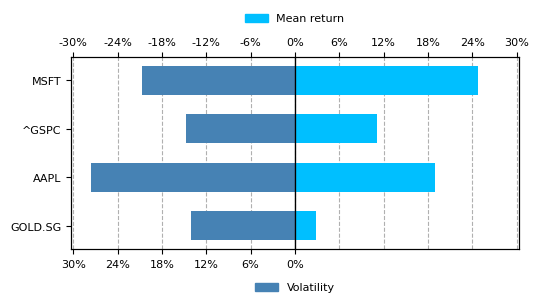

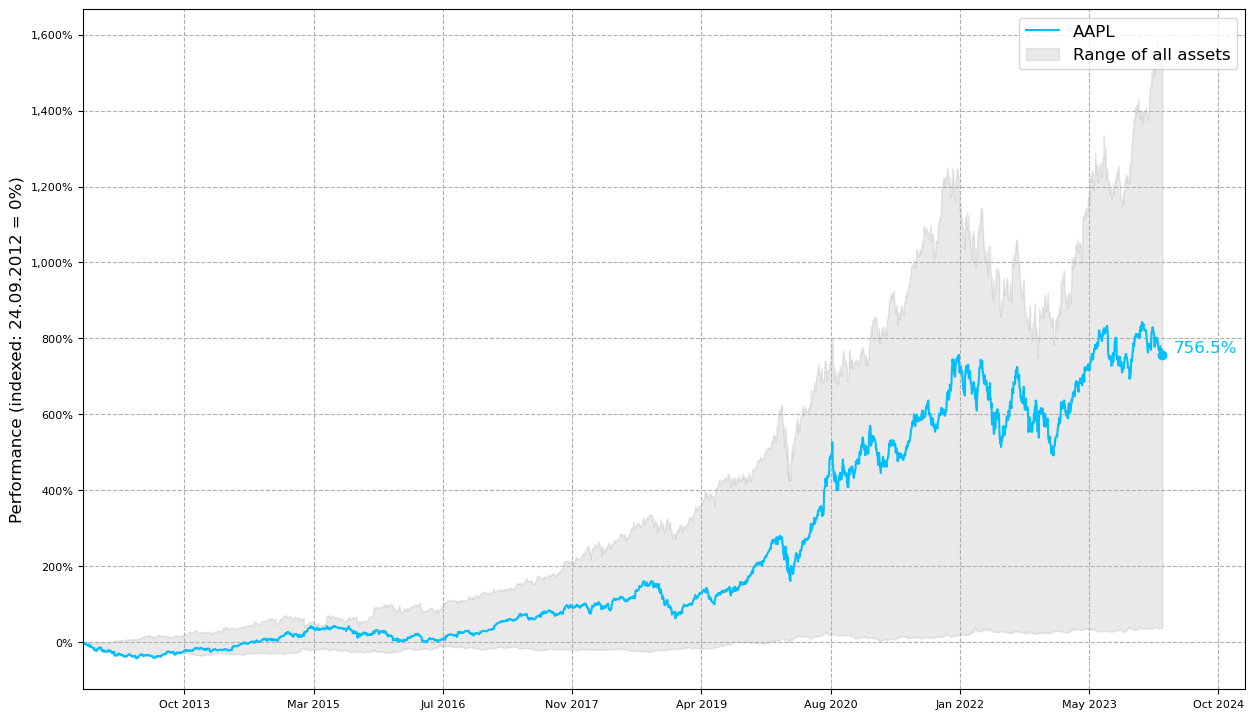

In [7]:
display_summary = pd.DataFrame()
display_summary["Full name"] = pd.Series(long_name_dict)
display_summary["Mean return p.a."] = summary["mean return"].map('{:.2%}'.format)
display_summary["Volatility p.a."] = summary["standard deviation"].map('{:.2%}'.format)
display_summary["Sharpe ratio"] = (summary["mean return"]- rf_l) / summary['standard deviation']
display_summary["YTD return"] = ytd_returns.map('{:.2%}'.format)
display_summary["Maximum drawdown"] = max_dds.map('{:.2%}'.format)
#display_summary["Mean return p.a."] = display_summary["Mean return p.a."].map('{:.2%}'.format)
#display_summary["Volatility p.a."] = display_summary["Volatility p.a."].map('{:.2%}'.format)
#display_summary["YTD return"] = display_summary["YTD return"].map('{:.2%}'.format)
display_summary.sort_values("Sharpe ratio", inplace=True, ascending=False)

visualize_summary(summary)

tickers_chosen = ["AAPL"]
visualize_performance(daily_adjusted_closing_prices, tickers_chosen)



In [8]:
market_proxy_input = st.text_input("As per default, the S&P 500 Index (^GSPC) is used as a proxy for the market portfolio. If you consider another index more suitable for your analysis, you can enter its [Yahoo Finace](https://finance.yahoo.com) ticker below (E.g. STOXX Europe 600: ^STOXX, Dax-Performance-Index: ^GDAXI, FTSE 100 Index: ^FTSE)")
riskfree_proxy_input = st.text_input("As per default, 10-year U.S. Treasury yields (^TNX) are used as a proxy for the risk-free rate. You may enter the ticker of a different proxy below (make sure the proxy is quoted in yields, not prices; e.g. 13-week U.S. Treasury yields: ^IRX, 5-year U.S. Treasury yields: ^FVX, 30-year U.S. Treasury yields: ^TYX)")

if market_proxy_input:
    market_proxy = market_proxy_input
else:
    market_proxy = "^GSPC"
    #market_proxy = "AAPL"
if riskfree_proxy_input:
    riskfree_proxy = riskfree_proxy_input
else:
    riskfree_proxy = "^TNX"

proxys_M_rf = [market_proxy, riskfree_proxy]

CAPM_data = yf.download(proxys_M_rf, period='max')["Adj Close"]
CAPM_data.dropna(inplace=True) 
CAPM_data = get_monthly_closing_prices(price_df_daily=CAPM_data)

download_sucess2 = False
if len(CAPM_data) < 1:
    st.error("Asset could not be found.")
else:
    if market_proxy_input or riskfree_proxy_input:
        st.success("Proxy updated!")
    download_sucess2 = True

if download_sucess2:
    CAPM_quotes = pd.DataFrame()
    CAPM_quotes[["Market", "risk-free"]] = CAPM_data[proxys_M_rf]
    CAPM_quotes["risk-free"] = CAPM_quotes["risk-free"]/100
    CAPM_quotes = CAPM_quotes.merge(montly_adjusted_closing_prices, left_index=True, right_index=True, how="inner")
    CAPM_returns = np.log(CAPM_quotes / CAPM_quotes.shift(1))
    CAPM_returns["risk-free"] = CAPM_quotes["risk-free"]*(1/12)
    CAPM_returns["MRP"] = CAPM_returns["Market"] - CAPM_returns["risk-free"]
    
    for asset in monthly_log_returns.columns:
        CAPM_returns[f"{asset}-rf"] = CAPM_returns[asset] - CAPM_returns["risk-free"]

    CAPM_returns.dropna(inplace=True)

CAPM_returns

[*********************100%%**********************]  2 of 2 completed


,Market,risk-free,AAPL,GOLD.SG,MSFT,^GSPC,MRP,AAPL-rf,GOLD.SG-rf,MSFT-rf,^GSPC-rf
Date,,,,,,,,,,,
2012-10-31,-0.0200,0.0014,-0.1138,-0.0363,-0.0419,-0.0200,-0.0214,-0.1152,-0.0377,-0.0433,-0.0214
2012-11-30,0.0028,0.0013,-0.0125,-0.0089,-0.0615,0.0028,0.0015,-0.0138,-0.0103,-0.0628,0.0015
2013-01-31,0.0562,0.0017,-0.2507,-0.0735,0.0307,0.0562,0.0546,-0.2524,-0.0752,0.0290,0.0546
2013-02-28,0.0110,0.0016,-0.0256,-0.0143,0.0209,0.0110,0.0094,-0.0272,-0.0159,0.0193,0.0094
2013-03-28,0.0354,0.0015,0.0029,0.0300,0.0287,0.0354,0.0338,0.0013,0.0284,0.0272,0.0338
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31,-0.0222,0.0041,-0.0026,0.0686,0.0684,-0.0222,-0.0263,-0.0066,0.0645,0.0644,-0.0263
2023-11-30,0.0854,0.0036,0.1078,-0.0030,0.1160,0.0854,0.0818,0.1041,-0.0066,0.1123,0.0818
2023-12-29,0.0433,0.0032,0.0135,-0.0005,-0.0076,0.0433,0.0401,0.0103,-0.0037,-0.0108,0.0401


In [9]:

mean_rf = CAPM_returns["risk-free"].mean()*12
mean_MRP = CAPM_returns["MRP"].mean()*12

CAPM_summary = pd.DataFrame()
for asset in monthly_log_returns.columns:
    Y=CAPM_returns[f"{asset}-rf"]
    X= sm.add_constant(CAPM_returns["MRP"])
    regress = sm.OLS(Y, X)
    result = regress.fit()
    CAPM_summary.loc[asset,"Mean rf"] = mean_rf
    CAPM_summary.loc[asset,"Beta"] = float(result.params[1])
    CAPM_summary.loc[asset,"Mean MRP"] = mean_MRP
    CAPM_summary.loc[asset,"Fair return"] = CAPM_summary.loc[asset,"Mean rf"] + CAPM_summary.loc[asset,"Beta"]*CAPM_summary.loc[asset,"Mean MRP"]
    CAPM_summary.loc[asset,"Alpha"] = float(result.params[0]*12)
    CAPM_summary.loc[asset,"Mean return"] = CAPM_summary.loc[asset,"Fair return"] + CAPM_summary.loc[asset,"Alpha"]

display_CAPM_summary = pd.DataFrame()
display_CAPM_summary["Mean rf"] = CAPM_summary["Mean rf"].map('{:.2%}'.format)
display_CAPM_summary["Beta"] = CAPM_summary["Beta"].map('{:.2f}'.format)
display_CAPM_summary["Mean MRP"] = CAPM_summary["Mean MRP"].map('{:.2%}'.format)
display_CAPM_summary["Fair Return"] = CAPM_summary["Fair return"].map('{:.2%}'.format)
display_CAPM_summary["Alpha"] = CAPM_summary["Alpha"].map('{:.2%}'.format)
display_CAPM_summary["Mean Return"] = CAPM_summary["Mean return"].map('{:.2%}'.format)

display_CAPM_summary

,Mean rf,Beta,Mean MRP,Fair Return,Alpha,Mean Return
AAPL,2.33%,1.24,9.42%,13.97%,6.38%,20.36%
GOLD.SG,2.33%,-0.15,9.42%,0.88%,2.06%,2.93%
MSFT,2.33%,0.96,9.42%,11.34%,15.11%,26.45%
^GSPC,2.33%,1.00,9.42%,11.75%,-0.00%,11.75%


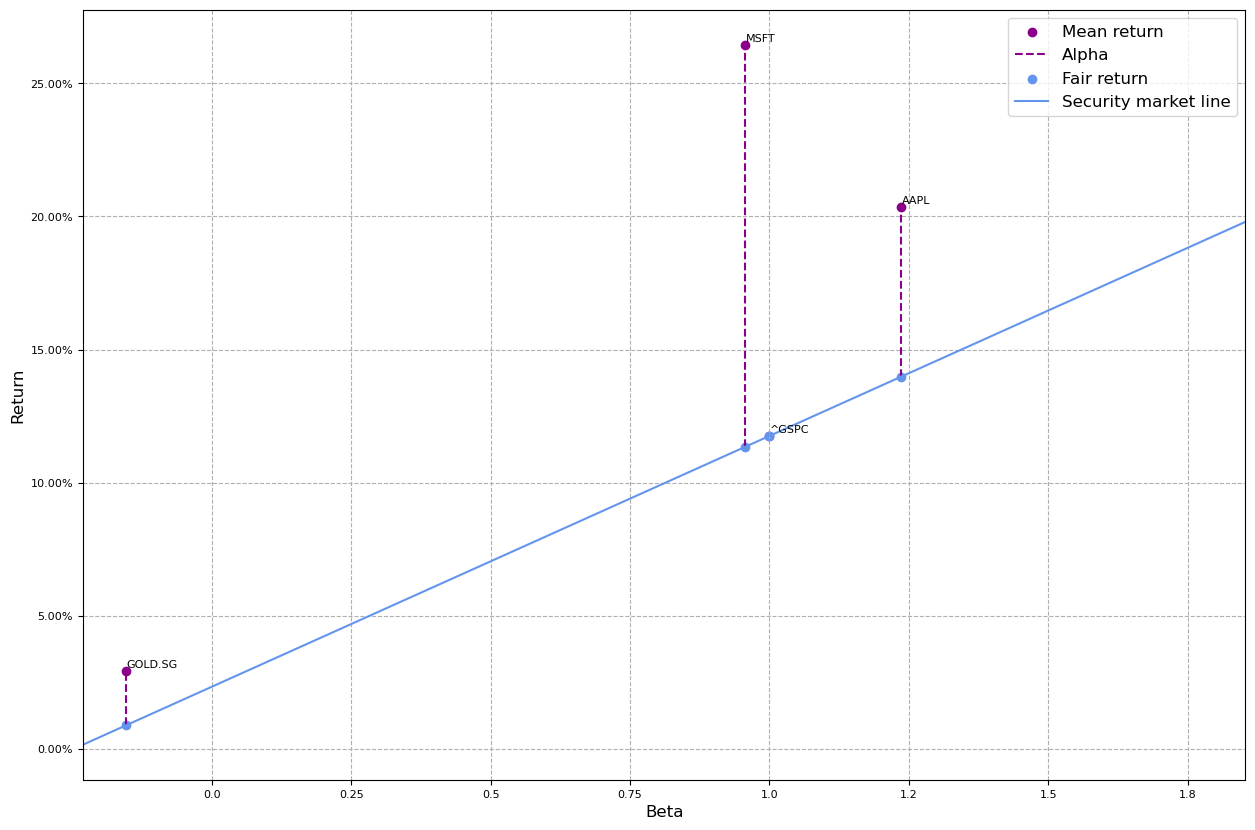

In [10]:

#Visualize SML
step = 0.001

color1 = 'cornflowerblue'
color2 = 'darkmagenta'

plt.figure(figsize=(15, 10))

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:,.2%}'.format))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:,.2}'.format))
plt.gca().set_xlim(left=min(min(CAPM_summary["Beta"])*1.5,0))
plt.gca().set_xlim(right=max(CAPM_summary["Beta"])*1.5)

plt.scatter(CAPM_summary["Beta"], CAPM_summary["Mean return"], color=color2, label="Mean return")

for i in summary.index:
    alpha_y = np.arange(min(CAPM_summary["Fair return"][i],CAPM_summary["Mean return"][i]), 
                        max(CAPM_summary["Fair return"][i],CAPM_summary["Mean return"][i]), step)
    alpha_x = np.ones((len(alpha_y),1))*CAPM_summary["Beta"][i]
    if i == summary.index[0]:
        plt.plot(alpha_x ,alpha_y, color=color2, linestyle='--', label="Alpha")
    else:
        plt.plot(alpha_x ,alpha_y, color=color2, linestyle='--')

plt.scatter(CAPM_summary["Beta"], CAPM_summary["Fair return"], color=color1, label="Fair return")

# SML
endpoint_sml = plt.gca().get_xlim()[1] 

betas_sml = np.arange(min(min(CAPM_summary["Beta"])*1.5,0), endpoint_sml, step)
return_sml = mean_rf + betas_sml*mean_MRP
plt.plot(betas_sml ,return_sml, color=color1, label='Security market line')


plt.legend(fontsize=12)
plt.xlabel("Beta", fontsize=12)
plt.ylabel("Return", fontsize=12)
plt.grid('on', ls="--")

labels = []
for i in summary.index:
    labels.append(plt.text(CAPM_summary["Beta"][i], CAPM_summary["Mean return"][i], i, size=8))
adjust_text(labels) 

plt.show()

In [11]:
# optimal leverage

daily_log_returns = np.log(daily_adjusted_closing_prices / daily_adjusted_closing_prices.shift(1))

daily_mean_returns = daily_log_returns.mean() 
daily_std_returns = daily_log_returns.std() 

asset_name = "AAPL"

daily_return = daily_mean_returns[asset_name]
daily_vola = daily_std_returns[asset_name]

In [12]:



leverage = 2
reference_rate = 0.05
expense_ratio = 0.0035
assumed_trading_days = 252
delta_t = 1/assumed_trading_days

daily_leverage_cost = ((leverage-1)*reference_rate + expense_ratio)*delta_t

# run monte carlo simmulation
sim_runs = 50000
daily_return_sim = np.log(1 + leverage*(daily_return + daily_vola*np.random.normal(0, 1, size=(sim_runs, assumed_trading_days))) - daily_leverage_cost)

daily_compounded_annual_returns = np.sum(daily_return_sim, axis=1)
daily_compounded_annual_returns

mean_daily_compounded_annual_return = daily_compounded_annual_returns.mean()
std_daily_compounded_annual_return = daily_compounded_annual_returns.std()
std_daily_compounded_annual_return
#simulation_df = pd.DataFrame(daily_return_sim)
#simulation_df

0.5763188952241705

In [13]:
def simulate_leveraged_daily_compounded_annual_return(daily_return, 
                                                      daily_vola, 
                                                      leverage, 
                                                      reference_rate, 
                                                      expense_ratio, 
                                                      assumed_trading_days,
                                                      sim_runs):
    delta_t = 1/assumed_trading_days
    daily_leverage_cost = ((leverage-1)*reference_rate + expense_ratio)*delta_t
    
    # run monte carlo simmulation
    daily_return_sim = np.log(1 + leverage*(daily_return + daily_vola*np.random.normal(0, 1, size=(sim_runs, assumed_trading_days))) - daily_leverage_cost)

    daily_compounded_annual_returns = np.sum(daily_return_sim, axis=1)

    mean_daily_compounded_annual_return = daily_compounded_annual_returns.mean()
    std_daily_compounded_annual_return = daily_compounded_annual_returns.std()
    
    return mean_daily_compounded_annual_return, std_daily_compounded_annual_return

In [14]:
def create_leverage_sim_visual(results_df):
    # Create figure and axis objects
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot mean return on primary y-axis
    ax1.scatter(results_df['Leverage'], results_df['Mean_Return'], label='Simulated return', color='cornflowerblue')
    ax1.set_xlabel('Leverage')
    ax1.set_ylabel('Daily compounded annual return')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter('{:,.0%}'.format))

    plt.grid('on', ls="--")
    # Create secondary y-axis for standard deviation
    ax2 = ax1.twinx()
    ax2.scatter(results_df['Leverage'], results_df['Std_Return'], label='Simulated volatility', color='darkmagenta')
    ax2.set_ylabel('Volatility of annual returns')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter('{:,.0%}'.format))

    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines + lines2, labels + labels2, loc=0)

    # Display the plot
    plt.show()

C:\Users\Abler-Kratkey\AppData\Local\Temp\ipykernel_2964\1728153964.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Leverage': leverage,
C:\Users\Abler-Kratkey\AppData\Local\Temp\ipykernel_2964\1728153964.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Leverage': leverage,
C:\Users\Abler-Kratkey\AppData\Local\Temp\ipykernel_2964\1728153964.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Leverage': leverage,
C:\Users\Abler-Kratkey\AppData\Local\Temp\ipykernel_2964\1728153964.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


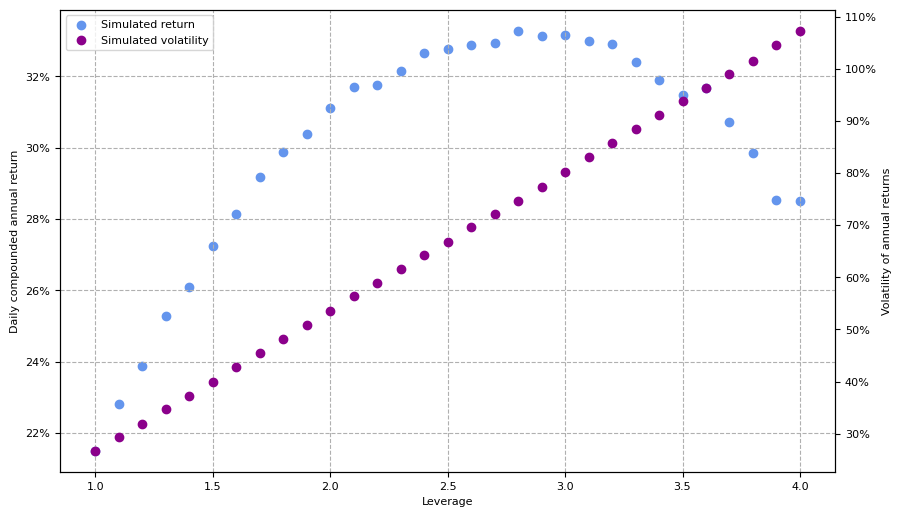

In [15]:
# optimal leverage

daily_log_returns = np.log(daily_adjusted_closing_prices / daily_adjusted_closing_prices.shift(1))

daily_mean_returns = daily_log_returns.mean() 
daily_std_returns = daily_log_returns.std() 

asset_name = "MSFT"

daily_return = daily_mean_returns[asset_name]
daily_vola = daily_std_returns[asset_name]

reference_rate = 0.05
expense_ratio = 0.0
assumed_trading_days = 252
sim_runs = 80000

# Define leverage levels
step_ = 0.1
leverage_levels = np.arange(1, 4 + step_, step_)

# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=['Leverage', 'Mean_Return', 'Std_Return'])

# Iterate over each leverage level
for leverage in leverage_levels:
    # Call the function for each leverage level
    mean_return, std_return = simulate_leveraged_daily_compounded_annual_return(daily_return, 
                                                                                daily_vola, 
                                                                                leverage, 
                                                                                reference_rate, 
                                                                                expense_ratio, 
                                                                                assumed_trading_days,
                                                                                sim_runs)
    # Append results to the DataFrame
    results_df = results_df.append({'Leverage': leverage, 
                                    'Mean_Return': mean_return, 
                                    'Std_Return': std_return}, 
                                   ignore_index=True)
    

create_leverage_sim_visual(results_df)

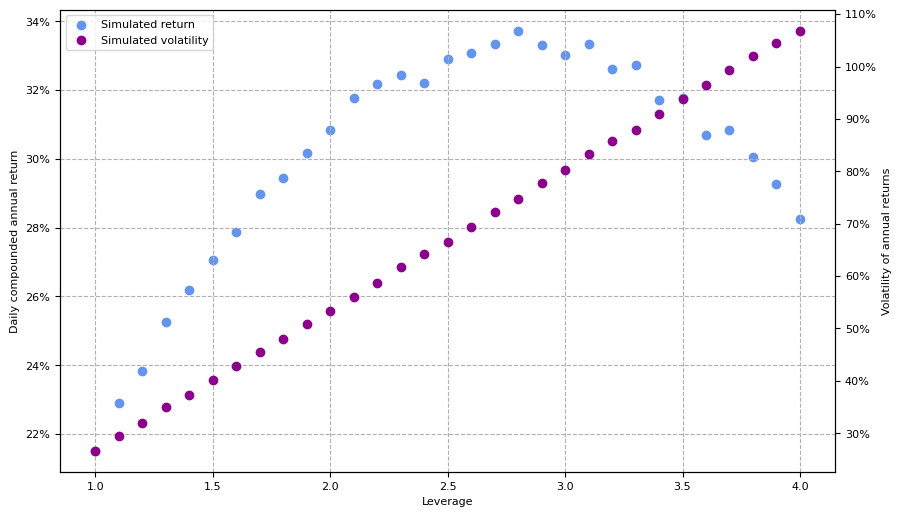

In [16]:
# optimal leverage

daily_log_returns = np.log(daily_adjusted_closing_prices / daily_adjusted_closing_prices.shift(1))

daily_mean_returns = daily_log_returns.mean() 
daily_std_returns = daily_log_returns.std() 

asset_name = "MSFT"

daily_return = daily_mean_returns[asset_name]
daily_vola = daily_std_returns[asset_name]

reference_rate = 0.05
expense_ratio = 0.0
assumed_trading_days = 252
sim_runs = 80000

# Define leverage levels
step_ = 0.1
leverage_levels = np.arange(1, 4 + step_, step_)

# Initialize an empty list to store DataFrames
dfs = []

# Iterate over each leverage level
for leverage in leverage_levels:
    # Call the function for each leverage level
    mean_return, std_return = simulate_leveraged_daily_compounded_annual_return(daily_return, 
                                                                                daily_vola, 
                                                                                leverage, 
                                                                                reference_rate, 
                                                                                expense_ratio, 
                                                                                assumed_trading_days,
                                                                                sim_runs)
    # Create a DataFrame for current leverage level
    df = pd.DataFrame({'Leverage': [leverage], 
                       'Mean_Return': [mean_return], 
                       'Std_Return': [std_return]})
    
    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames in the list along the rows axis
results_df = pd.concat(dfs, ignore_index=True)
    

create_leverage_sim_visual(results_df)

In [17]:
results_df

,Leverage,Mean_Return,Std_Return
0,1.0000,0.2151,0.2666
1,1.1000,0.2289,0.2949
2,1.2000,0.2383,0.3199
3,1.3000,0.2527,0.3492
4,1.4000,0.2618,0.3730
5,1.5000,0.2706,0.4010
6,1.6000,0.2787,0.4278
7,1.7000,0.2899,0.4549
8,1.8000,0.2944,0.4792
9,1.9000,0.3018,0.5092


In [18]:

row_highest_return = results_df.loc[results_df['Mean_Return'].idxmax()]
row_highest_return

Leverage      2.8000
Mean_Return   0.3373
Std_Return    0.7480
Name: 18, dtype: float64

In [19]:
def create_leverage_sim_visual(results_df):
    # Create figure and axis objects
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot mean return on primary y-axis
    ax1.scatter(results_df['Leverage'], results_df['Mean_Return'], label='Simulated return', color='cornflowerblue')
    ax1.set_xlabel('Leverage')
    ax1.set_ylabel('Daily compounded annual return')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter('{:,.0%}'.format))

    plt.grid('on', ls="--")
    # Create secondary y-axis for standard deviation
    ax2 = ax1.twinx()
    ax2.scatter(results_df['Leverage'], results_df['Std_Return'], label='Simulated volatility', color='darkmagenta')
    ax2.set_ylabel('Volatility of annual returns')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter('{:,.0%}'.format))

    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines + lines2, labels + labels2, loc=0)
    plt.style.use("default")

    # Display the plot
    plt.show()

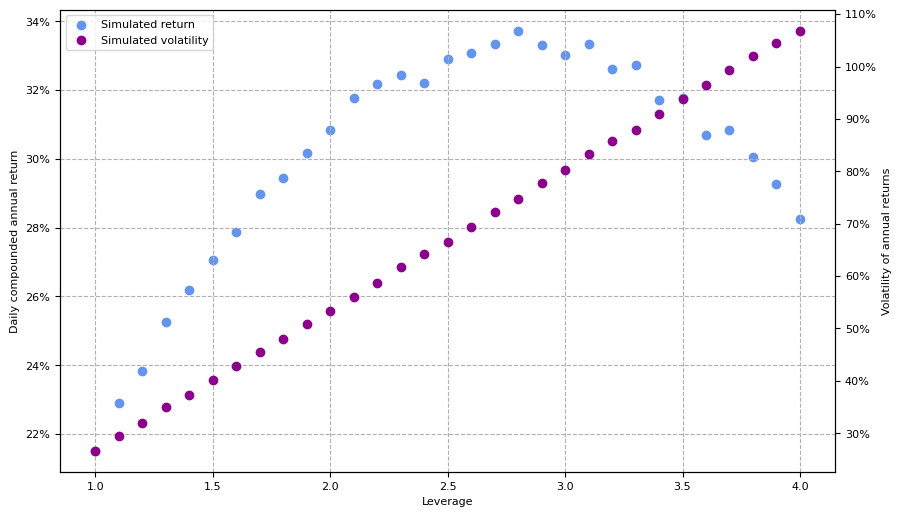

In [20]:
create_leverage_sim_visual(results_df)

In [21]:
SOFR_90_day = dr("SOFR90DAYAVG", 'fred',  start=now - datetime.timedelta(days=10))
SOFR_90_day.dropna(inplace=True)
SOFR_90_day = float(SOFR_90_day.iloc[-1])
SOFR_90_day

5.35435

In [160]:
def pandas_rsi(df: pd.DataFrame, window_length: int = 14, output: str = None, price: str = 'Close'):
    """
    An implementation of Wells Wilder's RSI calculation as outlined in
    his 1978 book "New Concepts in Technical Trading Systems" which makes
    use of the α-1 Wilder Smoothing Method of calculating the average
    gains and losses across trading periods and the Pandas library.

    @author: https://github.com/alphazwest
    Args:
        df: pandas.DataFrame - a Pandas Dataframe object
        window_length: int - the period over which the RSI is calculated. Default is 14
        output: str or None - optional output path to save data as CSV
        price: str - the column name from which the RSI values are calcuated. Default is 'Close'

    Returns:
        DataFrame object with columns as such, where xxx denotes an inconsequential
        name of the provided first column:
            ['xxx', 'diff', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs', 'rsi']
    """
    # Calculate Price Differences using the column specified as price.
    df['diff1'] = df[price].diff(1)

    # Calculate Avg. Gains/Losses
    df['gain'] = df['diff1'].clip(lower=0).round(2)
    df['loss'] = df['diff1'].clip(upper=0).abs().round(2)

    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Calculate Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length

    # Calculate Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length

    # Calculate RS Values
    df['rs'] = df['avg_gain'] / df['avg_loss']

    # Calculate RSI
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))

    # Save if specified
    if output is not None:
        df.to_csv(output)

    return df

In [161]:
asset_data = yf.download("AAPL")
asset_data = asset_data.tail(200)

[*********************100%%**********************]  1 of 1 completed


In [162]:
period_RSI=14
asset_data = pandas_rsi(df=asset_data, window_length=period_RSI, price="Close")

C:\Users\Abler-Kratkey\AppData\Local\Temp\ipykernel_2964\1821341141.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df[price].diff(1)
C:\Users\Abler-Kratkey\AppData\Local\Temp\ipykernel_2964\1821341141.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gain'] = df['diff1'].clip(lower=0).round(2)
C:\Users\Abler-Kratkey\AppData\Local\Temp\ipykernel_2964\1821341141.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [163]:
def calculate_macd(data, price="Close", days_fast=12, days_slow=26, days_signal=9):
    short_ema = data[price].ewm(span=days_fast, adjust=False).mean()
    long_ema = data[price].ewm(span=days_slow, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=days_signal, adjust=False).mean()
    macd_hist = macd - signal
    return short_ema, long_ema, macd, signal, macd_hist


In [164]:
asset_data["macd_short_ema"], asset_data["macd_long_ema"], asset_data["macd"], asset_data["macd_signal"], asset_data["macd_hist"] = calculate_macd(asset_data, price="Close", days_fast=12, days_slow=26, days_signal=9)
asset_data

asset_data["70_line"] = 70
asset_data["30_line"] = 30

C:\Users\Abler-Kratkey\AppData\Local\Temp\ipykernel_2964\1002308221.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_data["macd_short_ema"], asset_data["macd_long_ema"], asset_data["macd"], asset_data["macd_signal"], asset_data["macd_hist"] = calculate_macd(asset_data, price="Close", days_fast=12, days_slow=26, days_signal=9)
C:\Users\Abler-Kratkey\AppData\Local\Temp\ipykernel_2964\1002308221.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_data["macd_short_ema"], asset_data["macd_long_ema

In [165]:
asset_data.index

DatetimeIndex(['2023-05-17', '2023-05-18', '2023-05-19', '2023-05-22',
               '2023-05-23', '2023-05-24', '2023-05-25', '2023-05-26',
               '2023-05-30', '2023-05-31',
               ...
               '2024-02-20', '2024-02-21', '2024-02-22', '2024-02-23',
               '2024-02-26', '2024-02-27', '2024-02-28', '2024-02-29',
               '2024-03-01', '2024-03-04'],
              dtype='datetime64[ns]', name='Date', length=200, freq=None)

C:\Users\Abler-Kratkey\AppData\Local\Temp\ipykernel_2964\1195805393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_data["ema"] = asset_data["Close"].ewm(span=200, adjust=False).mean()
C:\Users\Abler-Kratkey\AppData\Local\Temp\ipykernel_2964\1195805393.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_data["mav2"] = asset_data["Close"].rolling(26).mean()


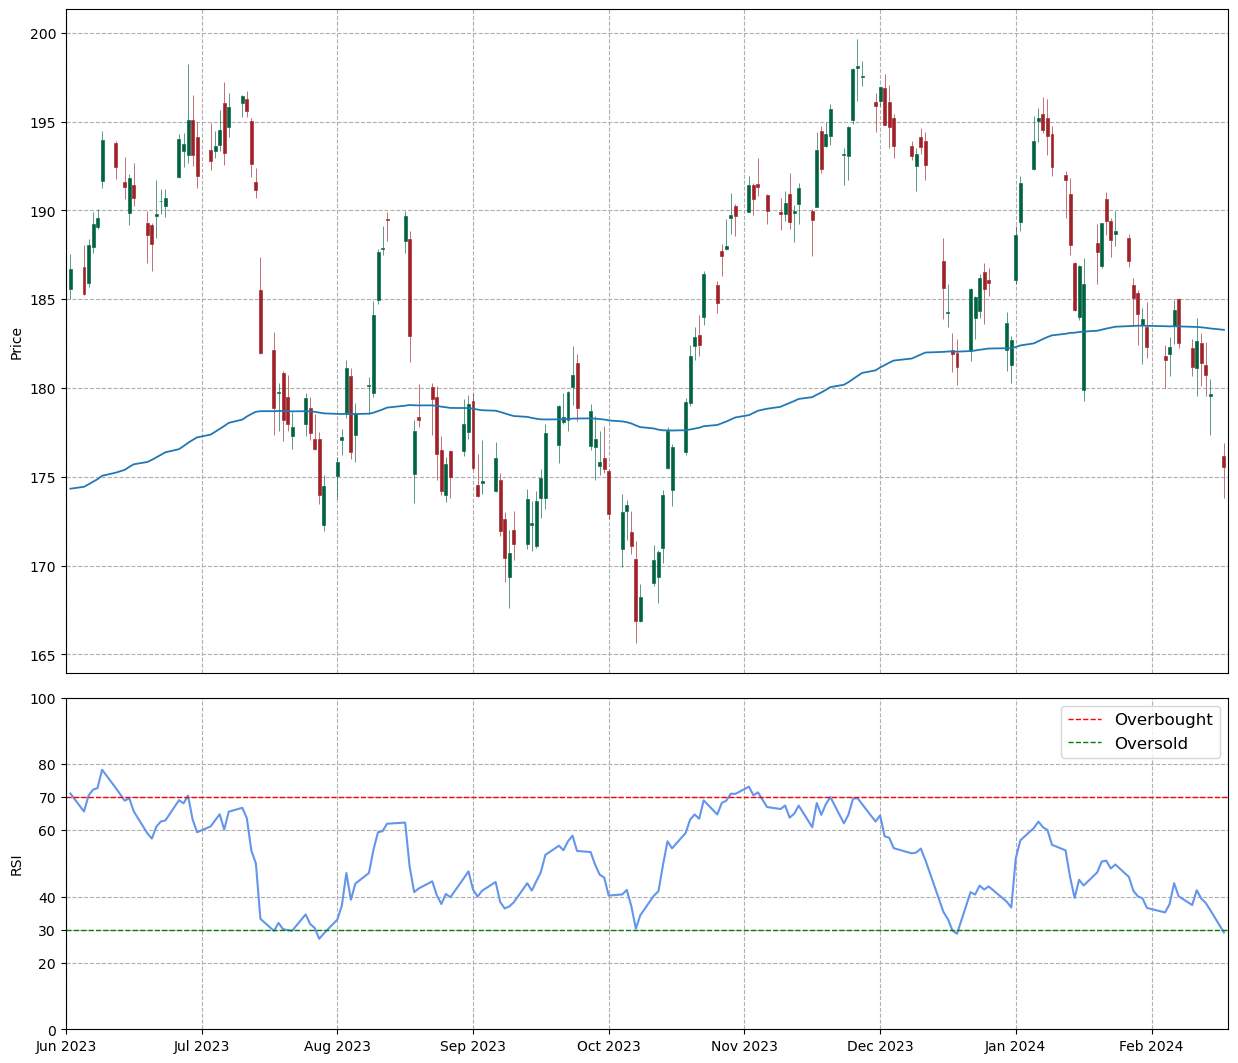

In [166]:
# calculate addplot data
asset_data["ema"] = asset_data["Close"].ewm(span=200, adjust=False).mean()
asset_data["mav2"] = asset_data["Close"].rolling(26).mean()

asset_data = asset_data.dropna()



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15), gridspec_kw={'height_ratios': [2, 1]})
ax1.xaxis.set_major_locator(MaxNLocator())
ax2.xaxis.set_major_locator(MaxNLocator())

# addplots
ap = [mpf.make_addplot(data=asset_data["ema"], type="line", ax=ax1),
      #mpf.make_addplot(data=asset_data["mav2"], type="line", ax=ax1)
      ]
      

s  = mpf.make_mpf_style(base_mpf_style="charles", y_on_right=False)


mpf.plot(
        asset_data,
        datetime_format='%b %Y',
        type="candle",
        ylabel='Price',
        ylabel_lower='Shares\nTraded',
        style=s,
        ax=ax1,
        show_nontrading=True,
        addplot=ap,
        xlim=(asset_data.head(1).index.max() - pd.Timedelta(days=1), asset_data.tail(1).index.max()+ pd.Timedelta(days=1))
    )


ax2 = asset_data["rsi"].plot(color="cornflowerblue", label="")

ax2.set_xlim(left=asset_data.head(1).index.max()- pd.Timedelta(days=1), right=asset_data.tail(1).index.max()+ pd.Timedelta(days=1))
ax2.yaxis.set_major_formatter(plt.FuncFormatter('{:,.0f}'.format))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format dates to show month and year


ax2.set_ylim(0,100)


ax1.grid('on', ls="--")
ax2.grid('on', ls="--")

# Remove x-axis tick marks from ax1
ax1.tick_params(axis='x', which='both', bottom=False, top=False)
ax1.set_xticklabels([])


ax2.set_ylabel('RSI')

# Remove x-axis label
ax2.set_xlabel('')

# Add horizontal lines
ax2.axhline(y=70, color='r', linestyle='--', linewidth=1, label='Overbought')
ax2.axhline(y=30, color='g', linestyle='--', linewidth=1, label='Oversold')


# Rotate x-axis labels to be horizontal
plt.xticks(rotation=0, ha='center')

# Add legend
plt.legend(fontsize=12)

# Adjust y-axis ticks
plt.yticks(list(plt.yticks()[0]) + [30, 70])

# Adjust layout
plt.subplots_adjust(hspace=0.05)  # Reduce vertical spacing between subplots
plt.style.use("default")
plt.minorticks_off()


plt.show()

In [167]:
date_format = '%b %d %Y'


# Remove x-axis tick marks from ax1
ax1.tick_params(axis='x', which='both', bottom=False, top=False)
ax1.set_xticklabels([])

[Text(19530.0, 0, ''),
 Text(19560.0, 0, ''),
 Text(19590.0, 0, ''),
 Text(19620.0, 0, ''),
 Text(19650.0, 0, ''),
 Text(19680.0, 0, ''),
 Text(19710.0, 0, ''),
 Text(19740.0, 0, ''),
 Text(19770.0, 0, ''),
 Text(19800.0, 0, '')]

In [168]:
def create_binary_colormap_for_plt_charts(data_values, two_color_list):

    cmap = matplotlib.colors.ListedColormap(two_color_list)

    # scale data
    denominator = max(data_values) - min(data_values)
    scaled_data = [(datum-min(data_values))/denominator for datum in data_values]

    colors = []
    for decimal in scaled_data:
        colors.append(cmap(decimal))

    return colors

rg_scaled_colors = create_binary_colormap_for_plt_charts(asset_data["macd_hist"], ["r","g"])

In [169]:
def create_colormap_for_plt_charts(data_values, color_list):
    
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", color_list)

    # scale data
    denominator = max(data_values) - min(data_values)
    scaled_data = [(datum-min(data_values))/denominator for datum in data_values]

    colors = []
    for decimal in scaled_data:
        colors.append(cmap(decimal))

    return colors


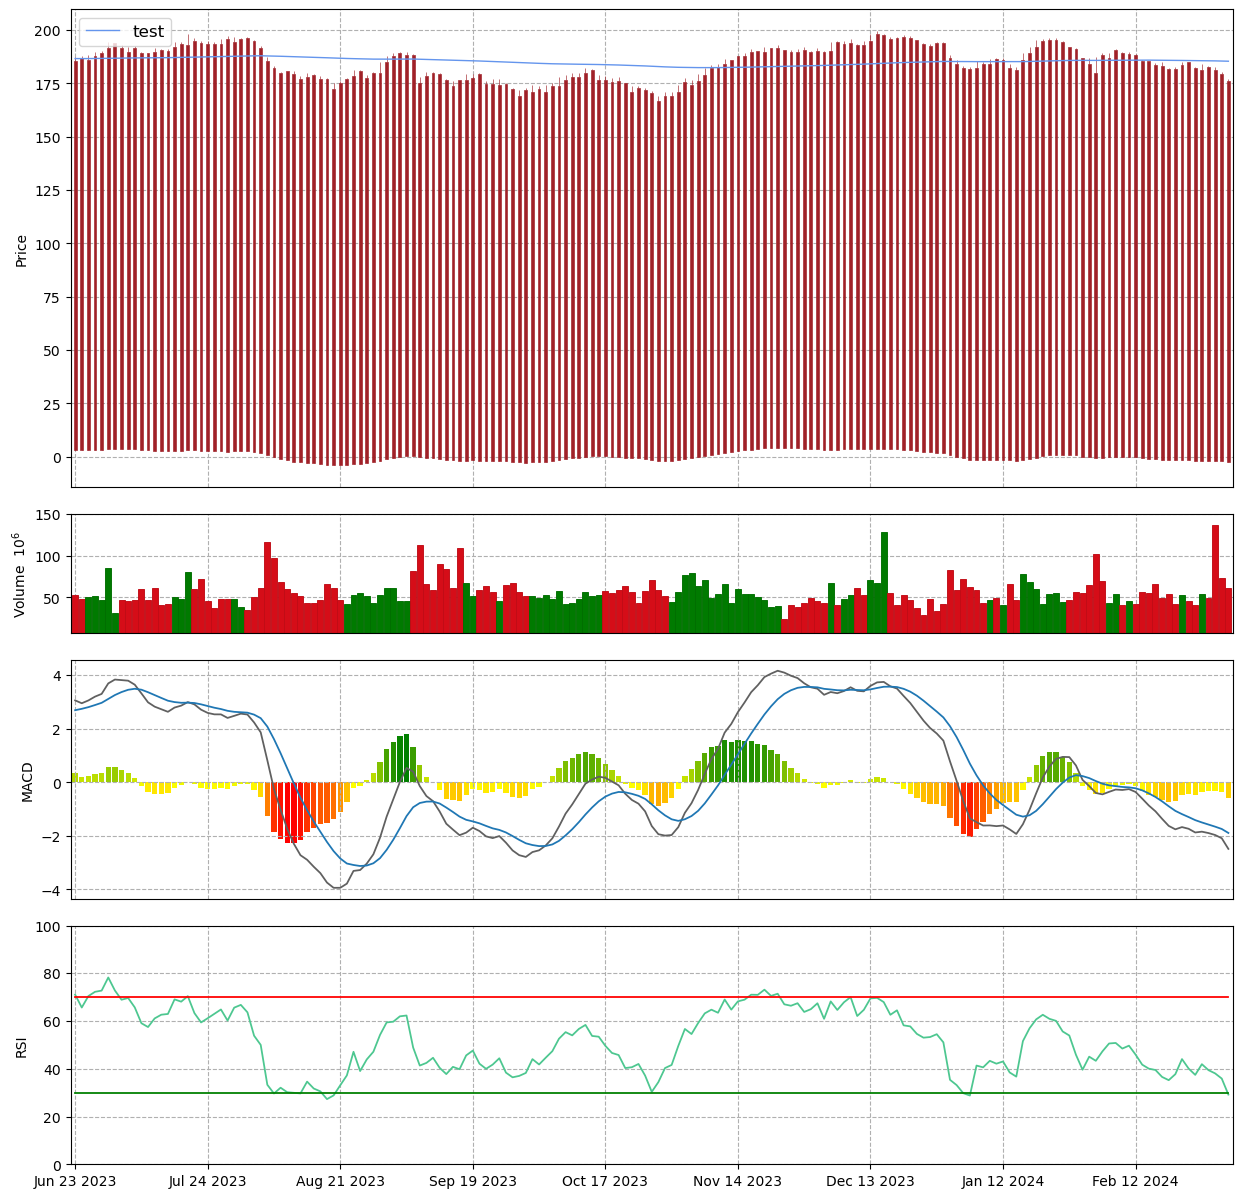

In [184]:


fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(4, 1, height_ratios=[4,1,2,2])

ax4 = plt.subplot(gs[3])
ax1 = plt.subplot(gs[0], sharex=ax4)
ax2 = plt.subplot(gs[1], sharex=ax4)
ax3 = plt.subplot(gs[2], sharex=ax4)

ap0 = [
    # ema
    mpf.make_addplot(data=asset_data["ema"], type="line", width=1.0, color="cornflowerblue", label="test", ax=ax1),

    # macd
    mpf.make_addplot((asset_data['macd']), color='#606060', ylabel='MACD', ax=ax3),
    mpf.make_addplot((asset_data['macd_signal']), color='#1f77b4', ax=ax3),
    mpf.make_addplot((asset_data['macd_hist']), type='bar', color=rg_scaled_colors, ax=ax3),

    # rsi
    mpf.make_addplot(asset_data['rsi'], ylim=[0, 100], color='#4dc790', ylabel='RSI', ax=ax4),
    mpf.make_addplot(asset_data['70_line'], color='r', ax=ax4),
    mpf.make_addplot(asset_data['30_line'], color='g', ax=ax4)
]

s = mpf.make_mpf_style(base_mpf_style="charles", y_on_right=False)

mpf.plot(asset_data,
         ax=ax1,
         style=s,
         addplot=ap0,
         volume=ax2,
         datetime_format=date_format,
         xlim=(asset_data.head(1).index.max() - pd.Timedelta(days=1), asset_data.tail(1).index.max() + pd.Timedelta(days=1)),
         type="candle")
fig.subplots_adjust(hspace=0.1)
ax1.tick_params(labelbottom=False, bottom=False, top=False)
ax1.grid('on', ls="--")
ax1.legend(fontsize=12, loc=2)
ax2.tick_params(labelbottom=False, bottom=False, top=False)
ax2.grid('on', ls="--")
ax3.tick_params(labelbottom=False, bottom=False, top=False)
ax3.grid('on', ls="--")
ax3.yaxis.set_label_position('left')
ax3.yaxis.tick_left()
ax4.grid('on', ls="--")

plt.style.use("default")
plt.minorticks_off()

# Rotate x-axis labels to be horizontal
plt.xticks(rotation=0, ha='center')

plt.show()

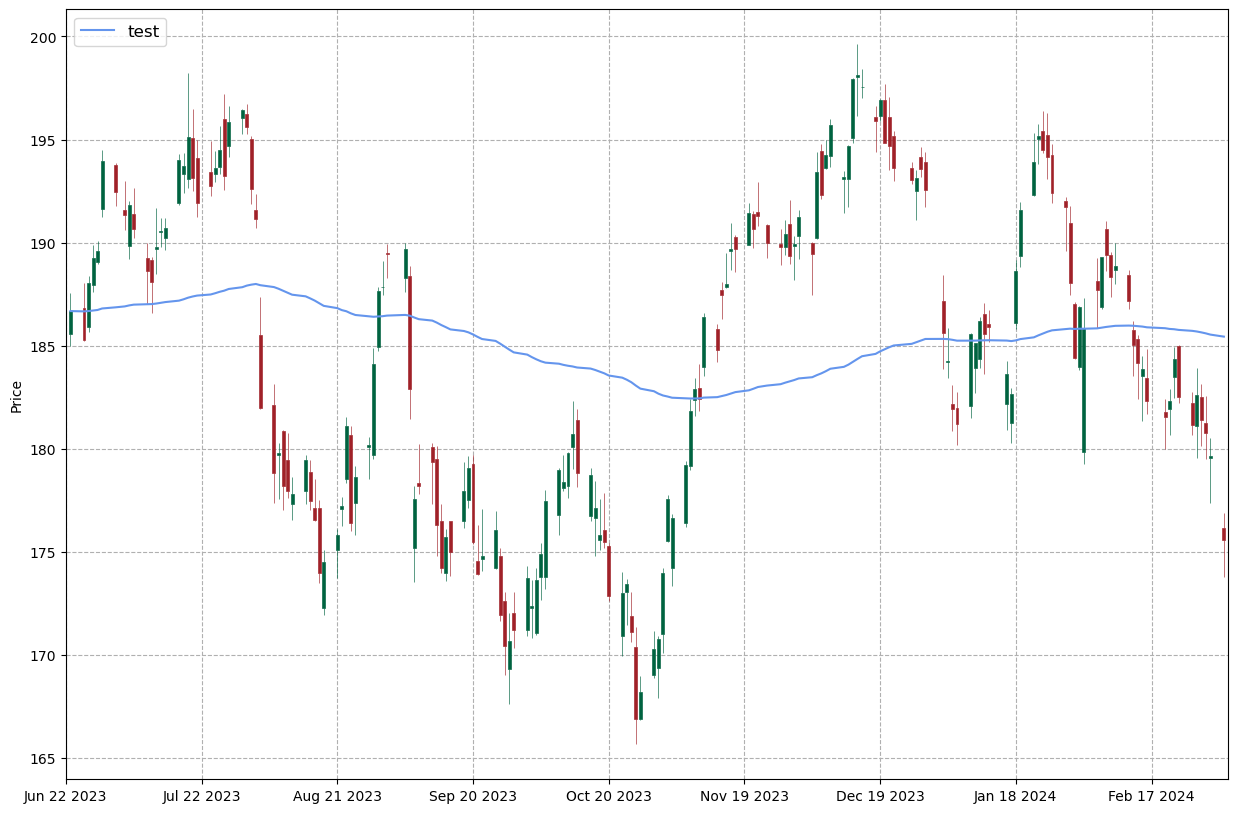

In [171]:
#date_format = '%Y-%m-%d'
#date_format = '%b %Y'
date_format = '%b %d %Y'

asset_data["ema"] = asset_data["Close"].ewm(span=200, adjust=False).mean()


fig, ax = plt.subplots(figsize=(15, 10))
ax.xaxis.set_major_locator(MaxNLocator())

# addplots
ap = [mpf.make_addplot(data=asset_data["ema"], type="line", width=1.5, color="cornflowerblue", label="test", ax=ax),
      #mpf.make_addplot(data=asset_data["mav2"], type="line", ax=ax1)
      ] 

s  = mpf.make_mpf_style(base_mpf_style="charles", y_on_right=False)

mpf.plot(
        asset_data,
        datetime_format=date_format,
        type="candle",
        ylabel='Price',
        ylabel_lower='Shares\nTraded',
        style=s,
        ax=ax,
        show_nontrading=True,
        addplot=ap,
        xlim=(asset_data.head(1).index.max() - pd.Timedelta(days=1), asset_data.tail(1).index.max()+ pd.Timedelta(days=1))
    )

ax.grid('on', ls="--")

# Rotate x-axis labels to be horizontal
plt.xticks(rotation=0, ha='center')

# Add legend
plt.legend(fontsize=12, loc=2)

# Adjust layout
plt.style.use("default")

plt.show()

2024-03-04 20:49:36.088 No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


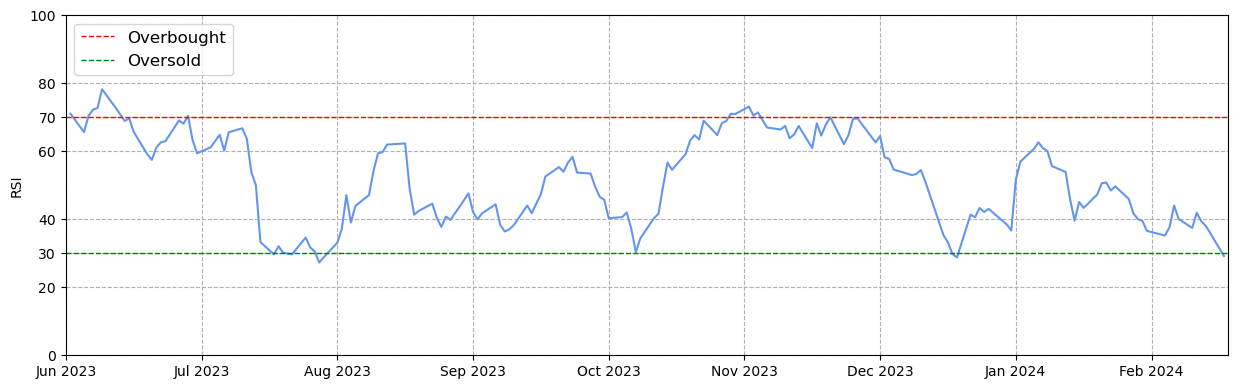

In [172]:
asset_data = asset_data.dropna()

asset_data["rsi"].plot(figsize=(15, 5), color="cornflowerblue", label="")

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:,.0f}'.format))
plt.gca().xaxis.set_major_locator(MaxNLocator())

plt.gca().set_ylim(0,100)
plt.gca().set_xlim(left=asset_data.head(1).index.max(), right=asset_data.tail(1).index.max())

plt.gca().set_ylabel('RSI')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format dates to show month and year
plt.grid('on', ls="--")
plt.legend(fontsize=12)

# Rotate x-axis labels to be horizontal
plt.xticks(rotation=0, ha='center')

# Remove x-axis label
plt.gca().set_xlabel('')

plt.gca().set_xlim(left=asset_data.head(1).index.max()- pd.Timedelta(days=1), right=asset_data.tail(1).index.max()+ pd.Timedelta(days=1))

# Add horizontal lines
plt.axhline(y=70, color='r', linestyle='--', linewidth=1, label='Overbought')
plt.axhline(y=30, color='g', linestyle='--', linewidth=1, label='Oversold')


# Add legend
plt.legend(fontsize=12, loc=2)

# Adjust y-axis ticks
plt.yticks(list(plt.yticks()[0]) + [30, 70])
plt.minorticks_off()


plt.show()


In [173]:
asset_data

,Open,High,Low,Close,Adj Close,Volume,diff1,gain,loss,avg_gain,...,rsi,macd_short_ema,macd_long_ema,macd,macd_signal,macd_hist,70_line,30_line,ema,mav2
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-23,185.5500,187.5600,185.0100,186.6800,185.9457,53079300,-0.3200,0.0000,0.3200,0.9338,...,71.0687,183.7717,180.7105,3.0611,2.6941,0.3670,70,30,186.6800,179.5108
2023-06-26,186.8300,188.0500,185.2300,185.2700,184.5413,48088700,-1.4100,0.0000,1.4100,0.8671,...,65.6495,184.0022,181.0483,2.9539,2.7461,0.2078,70,30,186.6660,179.9946
2023-06-27,185.8900,188.3900,185.6700,188.0600,187.3203,50730800,2.7900,2.7900,0.0000,1.0045,...,70.4509,184.6265,181.5677,3.0588,2.8086,0.2502,70,30,186.6798,180.4950
2023-06-28,187.9300,189.9000,187.6000,189.2500,188.5056,51216800,1.1900,1.1900,0.0000,1.0177,...,72.2336,185.3378,182.1367,3.2011,2.8871,0.3139,70,30,186.7054,181.0369
2023-06-29,189.0800,190.0700,188.9400,189.5900,188.8442,46347300,0.3400,0.3400,0.0000,0.9693,...,72.7396,185.9920,182.6888,3.3031,2.9703,0.3328,70,30,186.7341,181.6288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-27,181.1000,183.9200,179.5600,182.6300,182.6300,54318900,1.4700,1.4700,0.0000,0.6144,...,41.9247,183.7788,185.6197,-1.8409,-1.4964,-0.3445,70,30,185.6907,187.2181
2024-02-28,182.5100,183.1200,180.1300,181.4200,181.4200,48953900,-1.2100,0.0000,1.2100,0.5706,...,39.4211,183.4159,185.3086,-1.8927,-1.5756,-0.3171,70,30,185.6482,186.7385
2024-02-29,181.2700,182.5700,179.5300,180.7500,180.7500,136682600,-0.6700,0.0000,0.6700,0.5298,...,38.0656,183.0058,184.9709,-1.9652,-1.6535,-0.3116,70,30,185.5995,186.1835


2024-03-04 20:49:36.280 No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


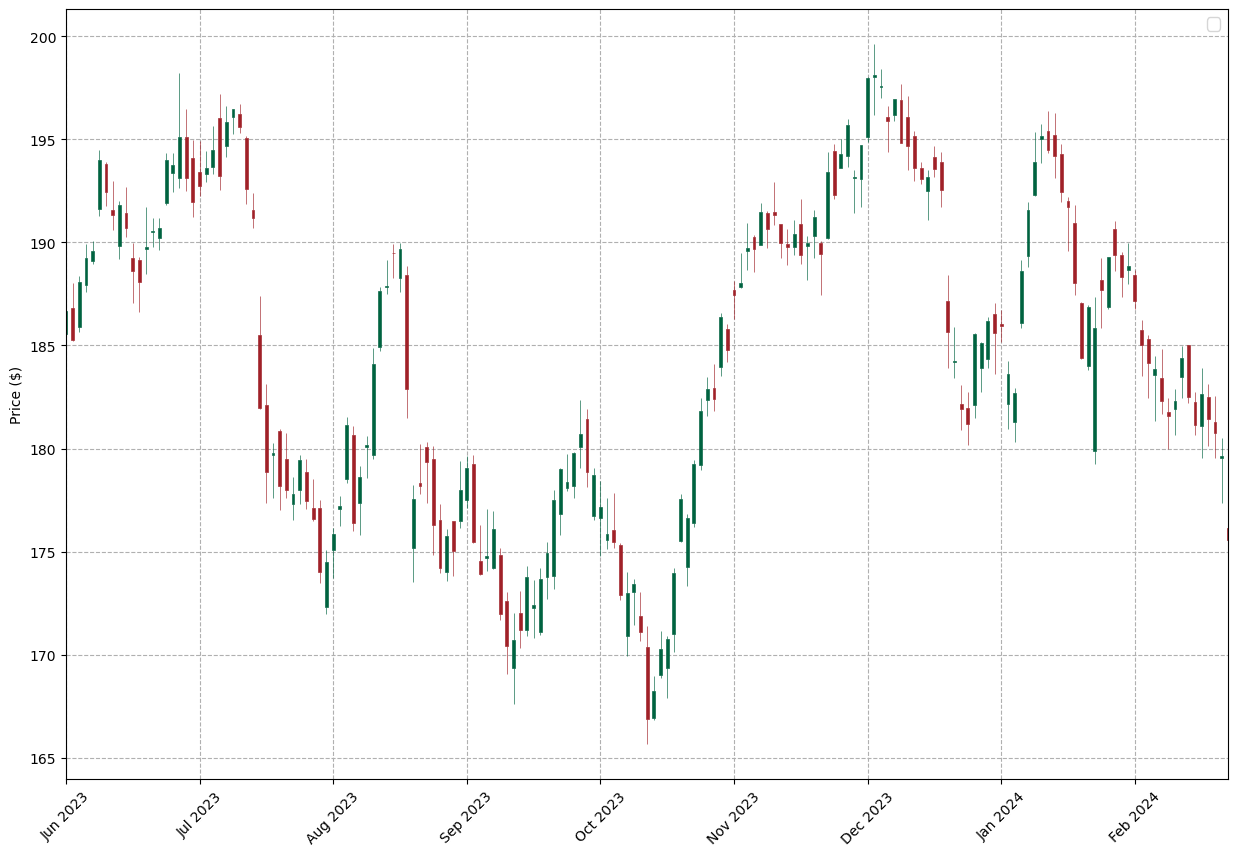

In [174]:
xticks_dates = get_monthly_closing_prices(asset_data).index

asset_data = asset_data.dropna()


fig, ax = plt.subplots(figsize=(15, 10))
#ax.set_xticks(xticks_dates)


s  = mpf.make_mpf_style(base_mpf_style="charles", y_on_right=False)

mpf.plot(
        asset_data,
        datetime_format='%b %Y',
        type="candle",
        ylabel='Price ($)',
        ylabel_lower='Shares\nTraded',
        style=s,
        ax=ax,
        xlim=(asset_data.head(1).index.max(), asset_data.tail(1).index.max())
    )

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:,.0f}'.format))
plt.gca().xaxis.set_major_locator(MaxNLocator())


plt.grid('on', ls="--")
plt.legend(fontsize=12)



plt.show()

In [175]:
asset_data.head(150)

,Open,High,Low,Close,Adj Close,Volume,diff1,gain,loss,avg_gain,...,rsi,macd_short_ema,macd_long_ema,macd,macd_signal,macd_hist,70_line,30_line,ema,mav2
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-23,185.5500,187.5600,185.0100,186.6800,185.9457,53079300,-0.3200,0.0000,0.3200,0.9338,...,71.0687,183.7717,180.7105,3.0611,2.6941,0.3670,70,30,186.6800,179.5108
2023-06-26,186.8300,188.0500,185.2300,185.2700,184.5413,48088700,-1.4100,0.0000,1.4100,0.8671,...,65.6495,184.0022,181.0483,2.9539,2.7461,0.2078,70,30,186.6660,179.9946
2023-06-27,185.8900,188.3900,185.6700,188.0600,187.3203,50730800,2.7900,2.7900,0.0000,1.0045,...,70.4509,184.6265,181.5677,3.0588,2.8086,0.2502,70,30,186.6798,180.4950
2023-06-28,187.9300,189.9000,187.6000,189.2500,188.5056,51216800,1.1900,1.1900,0.0000,1.0177,...,72.2336,185.3378,182.1367,3.2011,2.8871,0.3139,70,30,186.7054,181.0369
2023-06-29,189.0800,190.0700,188.9400,189.5900,188.8442,46347300,0.3400,0.3400,0.0000,0.9693,...,72.7396,185.9920,182.6888,3.3031,2.9703,0.3328,70,30,186.7341,181.6288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-22,192.3000,195.3300,192.2600,193.8900,193.6429,60133900,2.3300,2.3300,0.0000,1.1649,...,60.6873,188.1429,188.5509,-0.4079,-1.0642,0.6563,70,30,185.4065,190.1408
2024-01-23,195.0200,195.7500,193.8300,195.1800,194.9313,42355600,1.2900,1.2900,0.0000,1.1738,...,62.6197,189.2256,189.0419,0.1837,-0.8146,0.9983,70,30,185.5038,190.0338
2024-01-24,195.4200,196.3800,194.3400,194.5000,194.2521,53631300,-0.6800,0.0000,0.6800,1.0900,...,60.9198,190.0370,189.4462,0.5908,-0.5335,1.1243,70,30,185.5933,189.8950


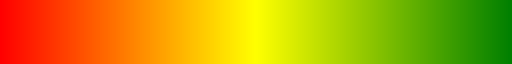

In [176]:
rg_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["r","yellow","g"])
rg_cmap

In [177]:
def create_colormap_for_plt_charts(data_values, color_list):
    
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", color_list)

    # scale data
    denominator = max(data_values) - min(data_values)
    scaled_data = [(datum-min(data_values))/denominator for datum in data_values]

    colors = []
    for decimal in scaled_data:
        colors.append(cmap(decimal))

    return colors

rg_scaled_colors = create_colormap_for_plt_charts(asset_data["macd_hist"], ["r","yellow","g"])
rg_scaled_colors

[(0.7058823529411764, 0.8529411764705882, 0.0, 1.0),
 (0.7843137254901961, 0.892156862745098, 0.0, 1.0),
 (0.7607843137254902, 0.8803921568627451, 0.0, 1.0),
 (0.7294117647058824, 0.8647058823529412, 0.0, 1.0),
 (0.7215686274509804, 0.8607843137254902, 0.0, 1.0),
 (0.596078431372549, 0.7980392156862746, 0.0, 1.0),
 (0.596078431372549, 0.7980392156862746, 0.0, 1.0),
 (0.6666666666666667, 0.8333333333333334, 0.0, 1.0),
 (0.7215686274509804, 0.8607843137254902, 0.0, 1.0),
 (0.807843137254902, 0.903921568627451, 0.0, 1.0),
 (0.9568627450980393, 0.9784313725490196, 0.0, 1.0),
 (1.0, 0.9254901960784314, 0.0, 1.0),
 (1.0, 0.9019607843137255, 0.0, 1.0),
 (1.0, 0.9019607843137255, 0.0, 1.0),
 (1.0, 0.9098039215686274, 0.0, 1.0),
 (0.9882352941176471, 0.9941176470588236, 0.0, 1.0),
 (0.9411764705882353, 0.9705882352941176, 0.0, 1.0),
 (0.8784313725490196, 0.9392156862745098, 0.0, 1.0),
 (0.9098039215686274, 0.9549019607843138, 0.0, 1.0),
 (0.9882352941176471, 0.9941176470588236, 0.0, 1.0),
 (1.0

In [178]:
def create_leverage_sim_visual(results_df):
    # Create figure and axis objects
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot mean return on primary y-axis
    ax1.scatter(results_df['Leverage'], results_df['Mean_Return'], label='Simulated return', color='cornflowerblue')
    ax1.set_xlabel('Leverage')
    ax1.set_ylabel('Daily compounded annual return')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter('{:,.0%}'.format))

    plt.grid('on', ls="--")
    # Create secondary y-axis for standard deviation
    ax2 = ax1.twinx()
    ax2.scatter(results_df['Leverage'], results_df['Std_Return'], label='Simulated volatility', color='darkmagenta')
    ax2.set_ylabel('Volatility of annual returns')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter('{:,.0%}'.format))

    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines + lines2, labels + labels2, loc=0)
    plt.style.use("default")

    # Display the plot
    plt.show()

2024-03-04 20:49:36.932 No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-03-04 20:49:36.944 No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


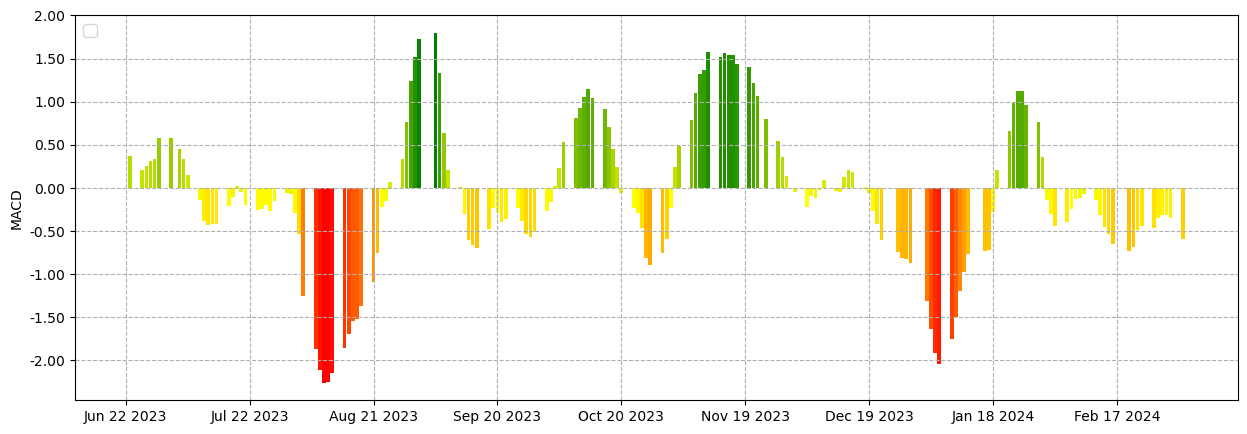

In [179]:
fig, ax1 = plt.subplots(figsize=(15, 5))


ax1.bar(x=asset_data.index, height=asset_data["macd_hist"], color=rg_scaled_colors, label="", width=0.9)
#ax1 = asset_data["macd_hist"].plot(figsize=(15, 5), color=rg_scaled_colors, label="",kind="bar", width=0.9)


ax1.yaxis.set_major_formatter(plt.FuncFormatter('{:,.2f}'.format))
ax1.xaxis.set_major_locator(MaxNLocator())

ax1.set_ylabel('MACD')

ax1.xaxis.set_major_formatter(mdates.DateFormatter(date_format))  # Format dates to show month and year
plt.grid('on', ls="--")
plt.legend(fontsize=12)

# Rotate x-axis labels to be horizontal
plt.xticks(rotation=0, ha='center')

# Remove x-axis label
ax1.set_xlabel('')


# Add legend
plt.legend(fontsize=12, loc=2)

plt.minorticks_off()


plt.show()


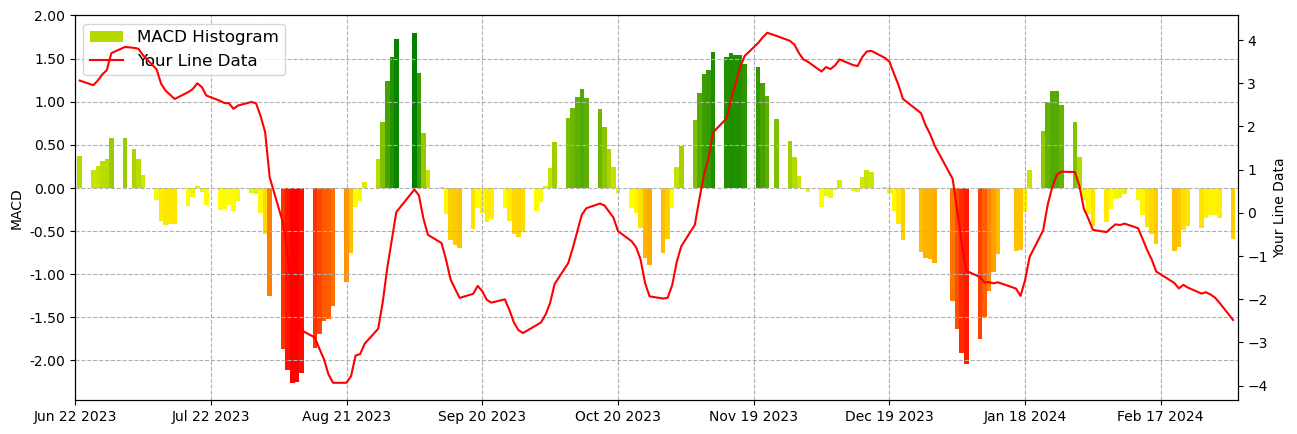

In [180]:
fig, ax1 = plt.subplots(figsize=(15, 5))

# Bar plot
ax1.bar(x=asset_data.index, height=asset_data["macd_hist"], color=rg_scaled_colors, label="MACD Histogram", width=1.0)
ax1.yaxis.set_major_formatter(plt.FuncFormatter('{:,.2f}'.format))
ax1.xaxis.set_major_locator(MaxNLocator())
ax1.set_ylabel('MACD')
ax1.xaxis.set_major_formatter(mdates.DateFormatter(date_format))  # Format dates to show month and year
ax1.set_xlim(left=asset_data.head(1).index.max()- pd.Timedelta(days=1), right=asset_data.tail(1).index.max()+ pd.Timedelta(days=1))
plt.grid('on', ls="--")
plt.xticks(rotation=0, ha='center')


# Line plot
ax2 = ax1.twinx()  # Create a twin axis sharing the same x-axis
ax2.plot(asset_data.index, asset_data["macd"], color='red', label="Your Line Data")
ax2.set_ylabel('Your Line Data')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=12)

plt.show()

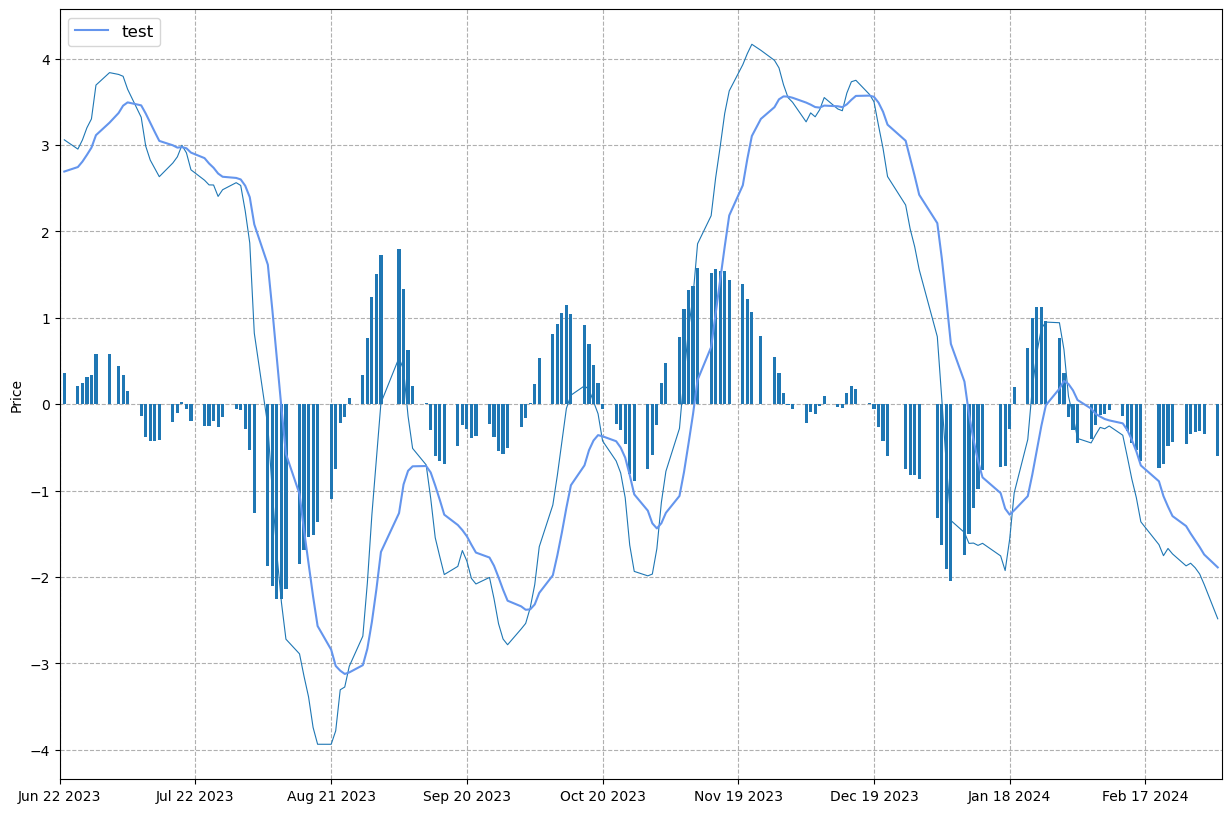

In [181]:

fig, ax = plt.subplots(figsize=(15, 10))
ax.xaxis.set_major_locator(MaxNLocator())

# trick mpf
asset_data_macd = asset_data
asset_data_macd["Close"] = asset_data_macd["macd"]

# addplots
ap = [mpf.make_addplot(data=asset_data_macd["macd_signal"], type="line", width=1.5, color="cornflowerblue", label="test", ax=ax),
      mpf.make_addplot(data=asset_data_macd["macd_hist"], type="bar", width=0.7, ax=ax)
      ] 

s  = mpf.make_mpf_style(base_mpf_style="charles", y_on_right=False)

mpf.plot(
        asset_data,
        datetime_format=date_format,
        type="line",
        ylabel='Price',
        ylabel_lower='Shares\nTraded',
        style=s,
        ax=ax,
        show_nontrading=True,
        addplot=ap,
        xlim=(asset_data.head(1).index.max() - pd.Timedelta(days=1), asset_data.tail(1).index.max()+ pd.Timedelta(days=1))
    )

ax.grid('on', ls="--")

# Rotate x-axis labels to be horizontal
plt.xticks(rotation=0, ha='center')

# Add legend
plt.legend(fontsize=12, loc=2)

# Adjust layout
plt.style.use("default")

plt.show()

2024-03-04 20:49:38.062 No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-03-04 20:49:38.072 No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


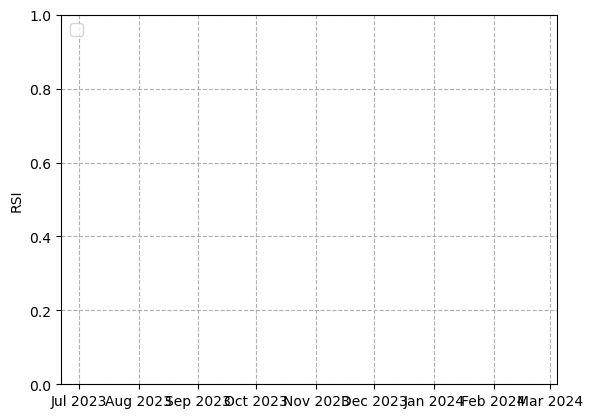

In [182]:




plt.gca().set_xlim(left=asset_data.head(1).index.max(), right=asset_data.tail(1).index.max())

plt.gca().set_ylabel('RSI')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format dates to show month and year
plt.grid('on', ls="--")
plt.legend(fontsize=12)

# Rotate x-axis labels to be horizontal
plt.xticks(rotation=0, ha='center')

# Remove x-axis label
plt.gca().set_xlabel('')

plt.gca().set_xlim(left=asset_data.head(1).index.max()- pd.Timedelta(days=1), right=asset_data.tail(1).index.max()+ pd.Timedelta(days=1))


# Add legend
plt.legend(fontsize=12, loc=2)

plt.minorticks_off()


plt.show()

In [183]:


plt.figure(figsize=(15, 5))

# Set the y-axis formatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Set the tick locations and labels
plt.xticks(sim_avg.index)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0f}'.format))


    plt.bar(sim_avg.index, sim_avg, color='deepskyblue', label="Capital", align='center')
    plt.bar(sim_avg.index, deposits, color='steelblue', label="Money invested", align='center')
if sim_avg.iloc[-1] < deposits[-1]:
    plt.bar(sim_avg.index, deposits, color='steelblue', label="Money invested", align='center')
    plt.bar(sim_avg.index, sim_avg, color='deepskyblue', label="Capital", align='center')

# Set the x-axis limits based on the minimum and maximum values in the index
plt.gca().set_xlim(left=sim_avg.index.min()-0.8)
plt.gca().set_xlim(right=sim_avg.index.max()+0.8)

# Rotate xticks if needed
if len(sim_avg.index) > 22:
    plt.xticks(rotation=45)
if len(sim_avg.index) > 60:
    plt.xticks(rotation=90)
if len(sim_avg.index) > 75:
    plt.gca().tick_params(axis='x', labelsize=8)
    
plt.gca().set_axisbelow(True)
plt.grid('on', ls="--")
plt.gca().xaxis.grid(False)
plt.legend(fontsize=12)

plt.show()

IndentationError: unexpected indent (1967417656.py, line 11)

In [ ]:
ax1.get_xticks()

array([19580., 19600., 19620., 19640., 19660., 19680., 19700., 19720.,
       19740., 19760., 19780., 19800.])

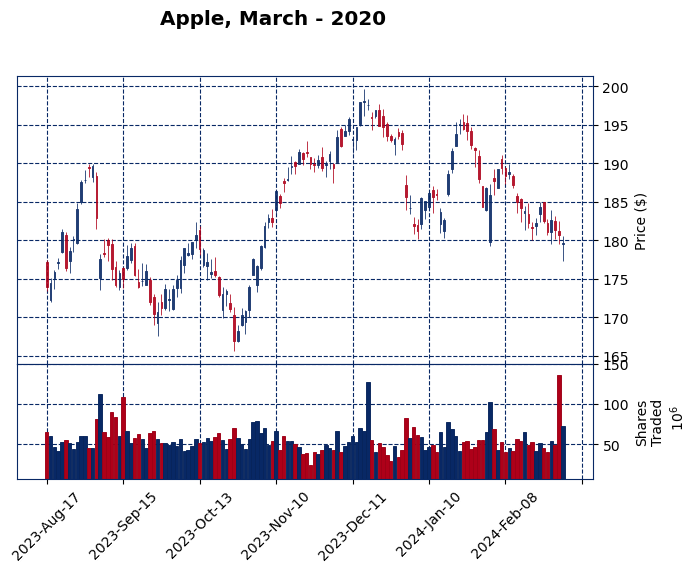

In [ ]:
mpf.plot(asset_data,
        type='candle',
        style='sas',
        title='Apple, March - 2020',
        ylabel='Price ($)',
        volume=True,
        ylabel_lower='Shares\nTraded',
        )

In [ ]:
mc = mpf.make_marketcolors(
                            up='g',down='r',
                            #edge=None,
                            wick={'up':'g','down':'r'},
                            volume='cornflowerblue',
                           )

s  = mpf.make_mpf_style(base_mpl_style="nightclouds", marketcolors=mc)

mpf.plot(
        asset_data,
        type="candle",
        title='Apple, March - 2020',
        ylabel='Price ($)',
        figratio=(15,10),
        volume=True,
        ylabel_lower='Shares\nTraded',
        style=s
    )

OSError: 'nightclouds' not found in the style library and input is not a valid URL or path; see `style.available` for list of available styles

In [ ]:
!pip show mplfinance

Name: mplfinance
Version: 0.12.10b0
Summary: Utilities for the visualization, and visual analysis, of financial data
Home-page: http://github.com/matplotlib/mplfinance
Author: MPL Developers
Author-email: matplotlib-users@python.org
License: BSD-style
Location: c:\users\abler-kratkey\anaconda3\lib\site-packages
Requires: matplotlib, pandas
Required-by: 


In [ ]:

benchmarking_data = create_performance_index(prices)

color_list = ['deepskyblue', 'steelblue', 'mediumslateblue', 'cornflowerblue', 'lightsteelblue', 
                'mediumslateblue', 'lightblue']

benchmarking_data_filtered = benchmarking_data.filter(list_of_names)
if len(list_of_names) > 0:
    benchmarking_data_filtered.plot(figsize=(15, 10), color=color_list)
else:
    plt.figure(figsize=(15, 10))


plt.fill_between(benchmarking_data.index, benchmarking_data.max(axis=1), benchmarking_data.min(axis=1),
                    color='grey', alpha=0.17, label="Range of all assets")

# Calculate the number of days to add
num_days = (benchmarking_data_filtered.index.max() - benchmarking_data_filtered.index.min()).days
days_to_add1 = num_days / 100
days_to_add2 = num_days / 13

# Plot scatter points at the end of each line
for col in benchmarking_data_filtered.columns:
    plt.scatter(benchmarking_data_filtered.index[-1], benchmarking_data_filtered[col].iloc[-1], color=color_list[list_of_names.index(col)], zorder=5)
    #text lablel is offset by a number of days to the right
    plt.text(benchmarking_data_filtered.index[-1] + pd.Timedelta(days=days_to_add1), benchmarking_data_filtered[col].iloc[-1], str(round(benchmarking_data_filtered[col].iloc[-1]*100, 2))+"%",color=color_list[list_of_names.index(col)], size=12, verticalalignment='bottom')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:,.0%}'.format))
plt.gca().xaxis.set_major_locator(MaxNLocator())
plt.gca().set_xlim(left=benchmarking_data.head(1).index.max())

plt.xlim(right=benchmarking_data.index.max() + pd.Timedelta(days=days_to_add2))  # Extend x-axis limit by number of days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format dates to show month and year
plt.grid('on', ls="--")
plt.ylabel(f"Performance (indexed: {benchmarking_data.head(1).index.max().strftime('%d.%m.%Y')} = 0%)", fontsize=12)
plt.legend(fontsize=12)

# Rotate x-axis labels to be horizontal
plt.xticks(rotation=0, ha='center')

# Remove x-axis label
plt.gca().set_xlabel('')

plt.show()

NameError: name 'prices' is not defined

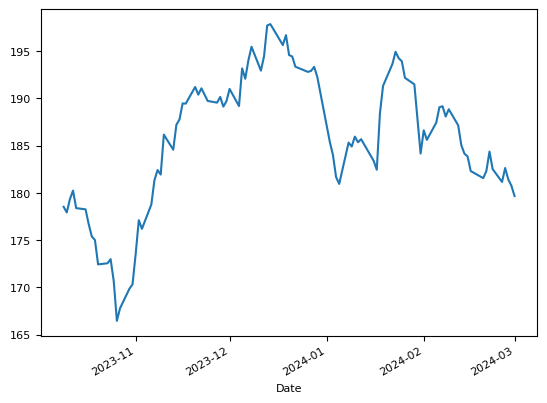

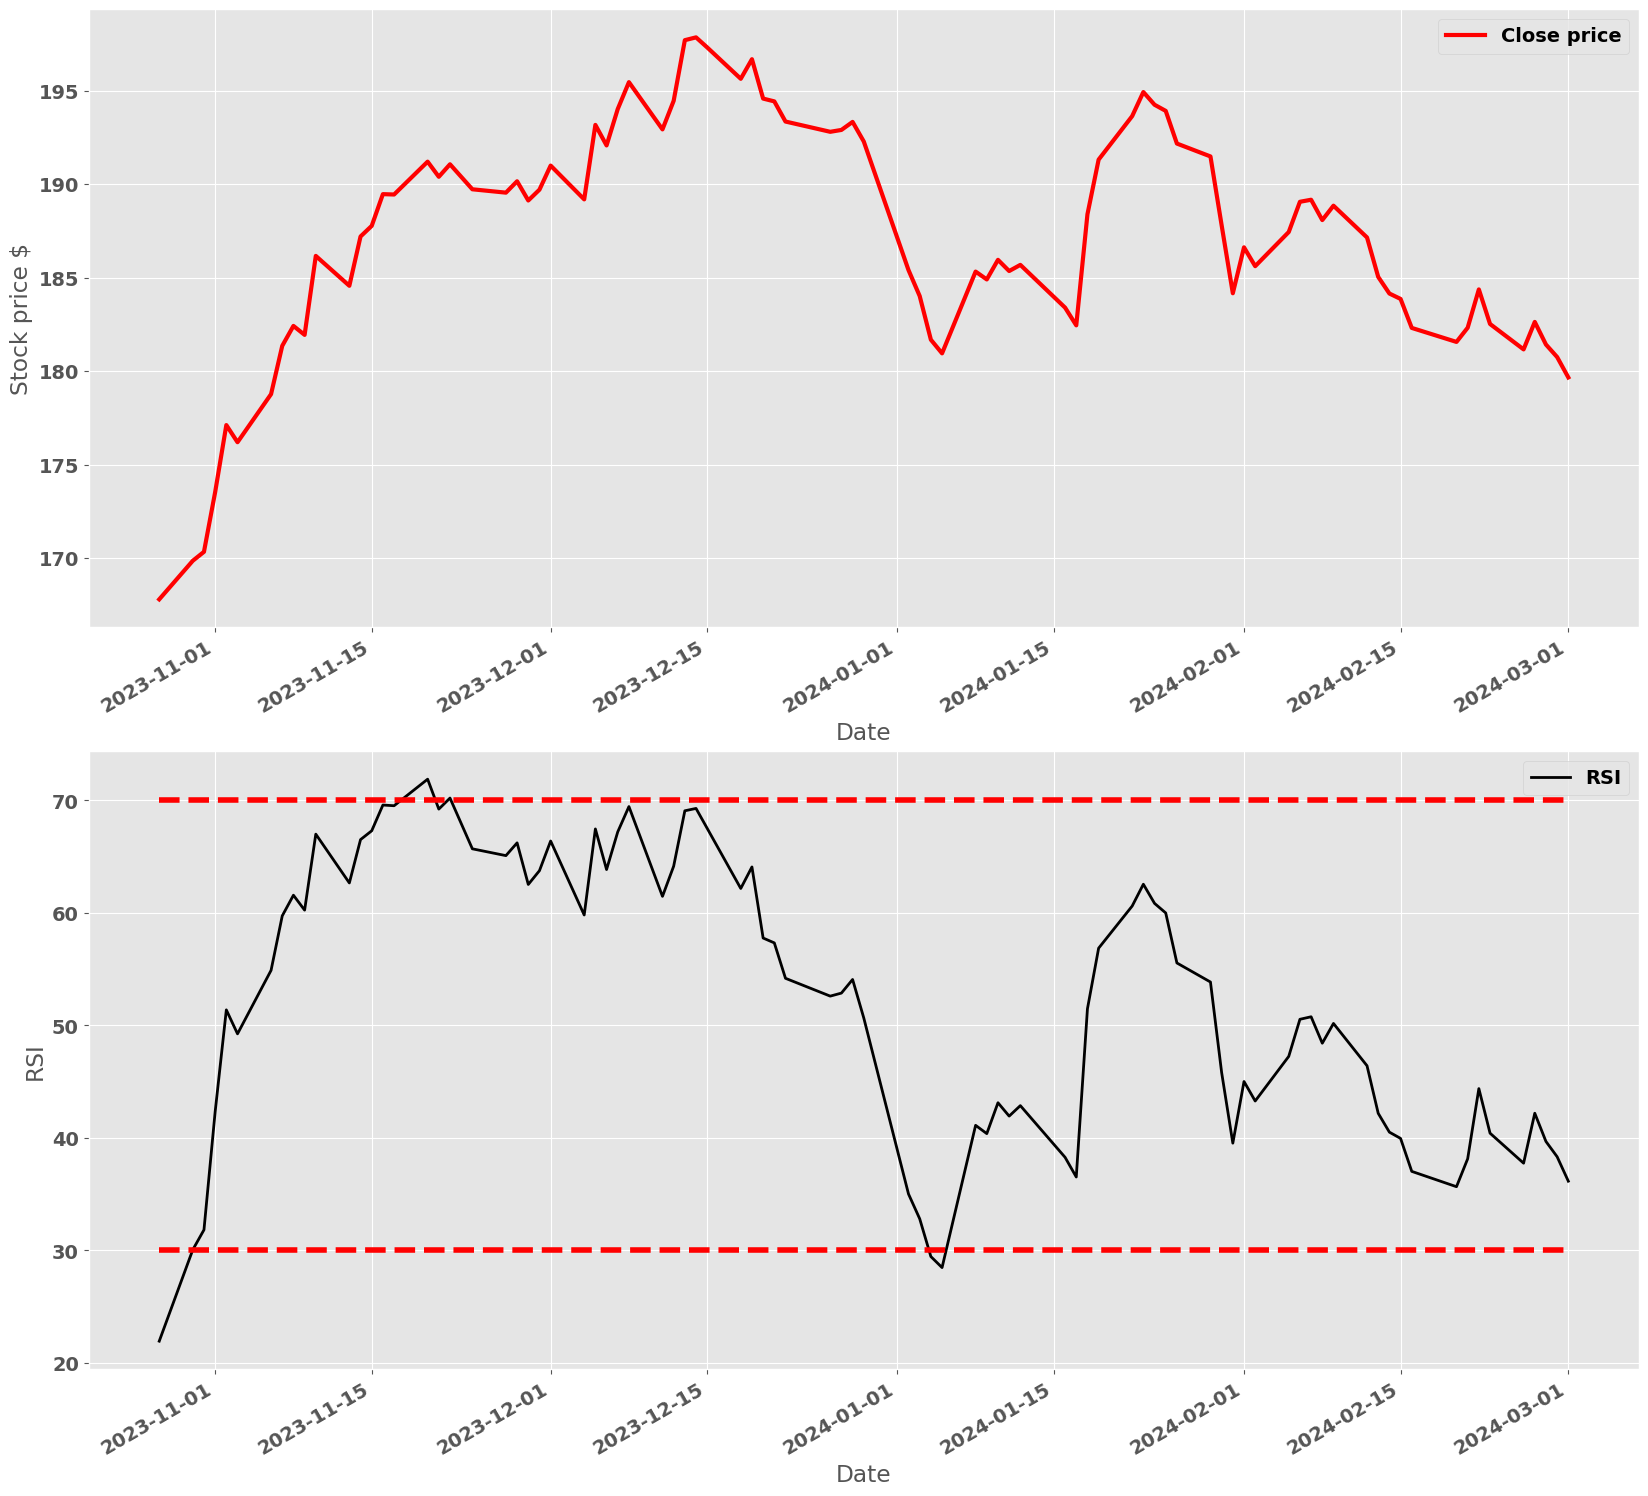

In [ ]:

 
# create the 30 and 70 limit lines
 
num_entries=RSI_series.values.size
 
line30=num_entries*[30]
line70=num_entries*[70]
 
# create the Pandas dataframe with 30 and 70 line limits 
lines30_70=pd.DataFrame({'30 limit': line30, '70 limit': line70},index=RSI_series.index)
 
     
# plot RSI and prices on the same graph
 
with plt.style.context('ggplot'):
    import matplotlib
    font = { 'weight' : 'bold',
        'size'   : 14}
    matplotlib.rc('font', **font)
    fig = plt.figure(figsize=(20,20))
    ax1=fig.add_subplot(211, ylabel='Stock price $')
    asset_data['Adj Close'].iloc[period_RSI:].plot(ax=ax1,color='r',lw=3,label='Close price',legend=True)
    ax2=fig.add_subplot(212, ylabel='RSI')
    RSI_series.plot(ax=ax2,color='k',lw=2,label='RSI',legend=True)
    lines30_70['30 limit'].plot(ax=ax2, color='r', lw=4, linestyle='--')
    lines30_70['70 limit'].plot(ax=ax2, color='r', lw=4, linestyle='--')
    plt.savefig('RSI.png')
    plt.show()